<a href="https://colab.research.google.com/github/silvesco94/zone_article1/blob/main/zone_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 44.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
import unicodedata
import statsmodels.api as sm

from pybaseball import statcast
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.formula.api import ols

# Pitch Zone Article

## Basic walk History information

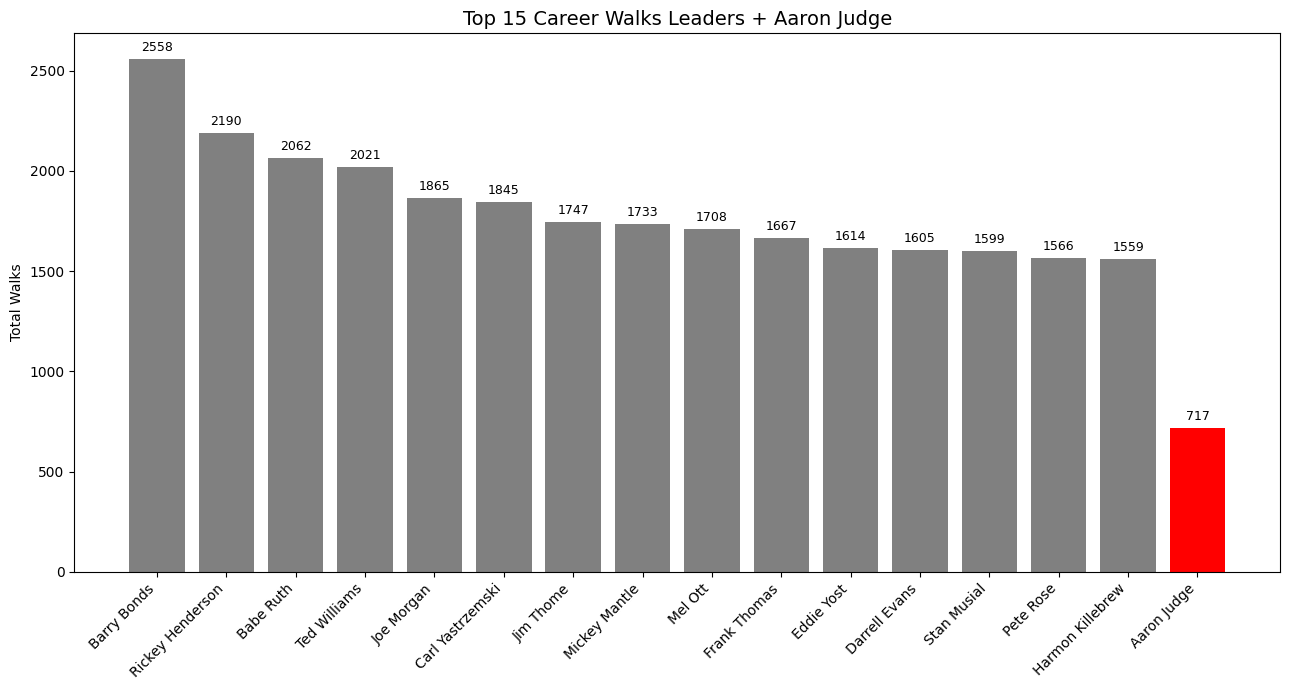

In [ ]:
walk_data = pd.read_csv('/content/basic walk data.csv')

# Step 1: Get top 15 by total walks
top_walks = walk_data[['Name', 'BB']].copy()
top_walks = top_walks.sort_values(by='BB', ascending=False).head(15)

# Step 2: Extract Aaron Judge explicitly
judge_row = walk_data[walk_data['Name'].str.strip().str.lower() == 'aaron judge']

# Step 3: Combine top 15 + Aaron Judge (remove duplicates just in case)
combined = pd.concat([top_walks, judge_row])
combined = combined.drop_duplicates(subset='Name', keep='first')

# Step 4: Move Aaron Judge to the end
non_judge = combined[~combined['Name'].str.strip().str.lower().eq('aaron judge')]
combined_final = pd.concat([non_judge, judge_row])

# Step 5: Highlight Judge
combined_final['highlight'] = combined_final['Name'].str.strip().str.lower() == 'aaron judge'

# Step 6: Plotting
plt.figure(figsize=(13, 7))
bars = plt.bar(
    combined_final['Name'],
    combined_final['BB'],
    color=combined_final['highlight'].map({True: 'red', False: 'gray'})
)

plt.title('Top 15 Career Walks Leaders + Aaron Judge', fontsize=14)
plt.ylabel('Total Walks')
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 25, f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## bb%

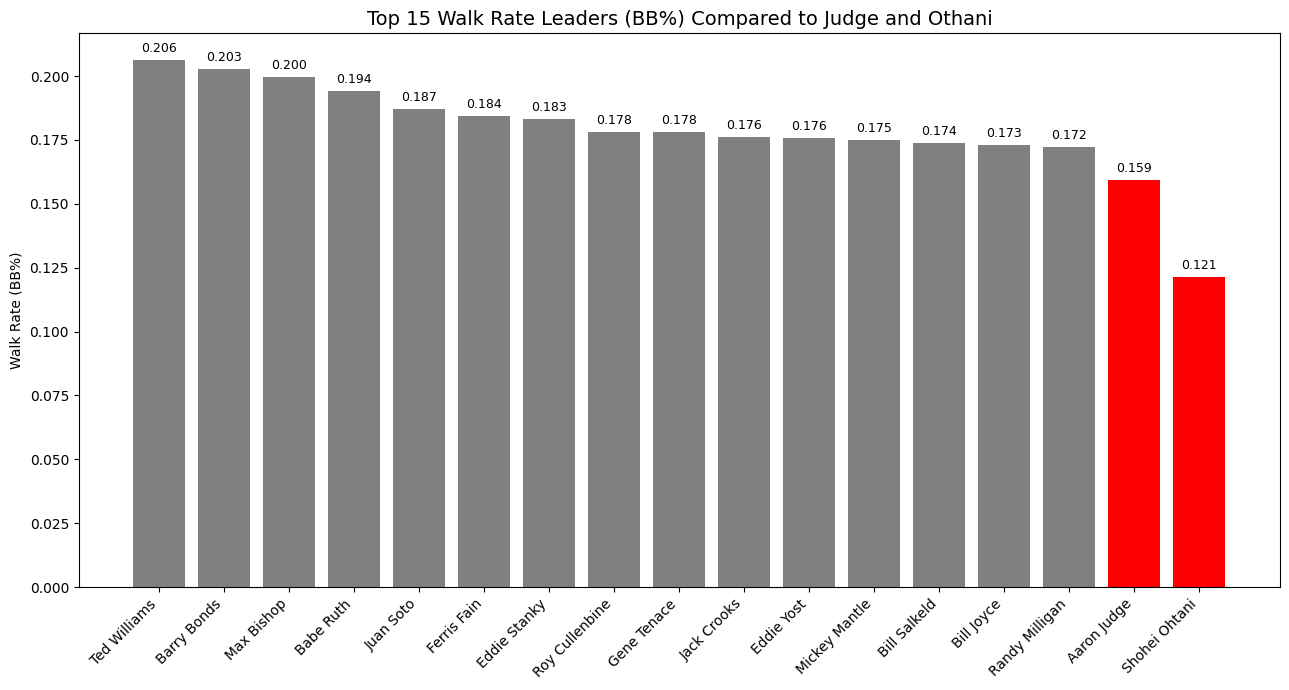

In [ ]:
# Step 1: Get top 15 by BB% (walk rate)
top_bb_rate = walk_data[['Name', 'BB%']].copy()
top_bb_rate = top_bb_rate.dropna(subset=['BB%'])
top_bb_rate = top_bb_rate.sort_values(by='BB%', ascending=False).head(15)

# Step 2: Extract Aaron Judge and Shohei Ohtani
judge_row = walk_data[walk_data['Name'].str.strip().str.lower() == 'aaron judge']
ohtani_row = walk_data[walk_data['Name'].str.strip().str.lower() == 'shohei ohtani']

# Step 3: Combine with top 15 and remove duplicates
combined_bb = pd.concat([top_bb_rate, judge_row, ohtani_row])
combined_bb = combined_bb.drop_duplicates(subset='Name', keep='first')

# Step 4: Move Judge and Ohtani to the end
is_judge = combined_bb['Name'].str.strip().str.lower() == 'aaron judge'
is_ohtani = combined_bb['Name'].str.strip().str.lower() == 'shohei ohtani'
non_special = combined_bb[~(is_judge | is_ohtani)]
special = combined_bb[is_judge | is_ohtani]
combined_final = pd.concat([non_special, special])

# Step 5: Highlight Judge and Ohtani
combined_final['highlight'] = combined_final['Name'].str.strip().str.lower().isin(['aaron judge', 'shohei ohtani'])

# Step 6: Plotting
plt.figure(figsize=(13, 7))
bars = plt.bar(
    combined_final['Name'],
    combined_final['BB%'],
    color=combined_final['highlight'].map({True: 'red', False: 'gray'})
)

plt.title('Top 15 Walk Rate Leaders (BB%) Compared to Judge and Othani', fontsize=14)
plt.ylabel('Walk Rate (BB%)')
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

IBB by Season

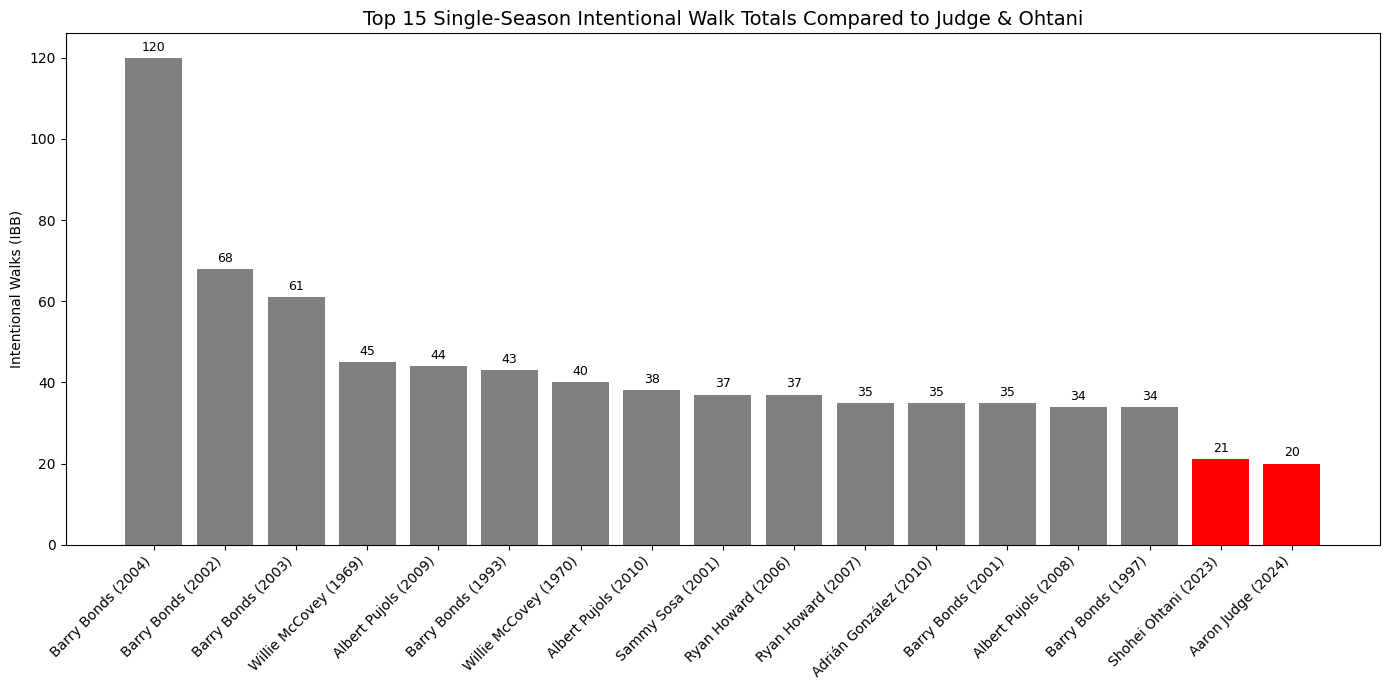

In [ ]:
# Load the season-level data
season_data = pd.read_csv('/content/by season.csv')

# Select relevant columns and clean data
season_data = season_data[['Name', 'Season', 'IBB']].dropna(subset=['IBB'])
season_data['IBB'] = pd.to_numeric(season_data['IBB'], errors='coerce')
season_data = season_data.dropna(subset=['IBB'])

# Get top 15 highest IBB seasons
top_ibb_seasons = season_data.sort_values(by='IBB', ascending=False).head(15)

# Get Shohei Ohtani and Aaron Judge's highest IBB seasons
ohtani_max = season_data[season_data['Name'].str.strip().str.lower() == 'shohei ohtani'].sort_values(by='IBB', ascending=False).head(1)
judge_max = season_data[season_data['Name'].str.strip().str.lower() == 'aaron judge'].sort_values(by='IBB', ascending=False).head(1)

# Combine and remove duplicates
combined_ibb = pd.concat([top_ibb_seasons, ohtani_max, judge_max])
combined_ibb = combined_ibb.drop_duplicates(subset=['Name', 'Season'], keep='first')

# Highlight Judge and Ohtani
combined_ibb['highlight'] = combined_ibb['Name'].str.strip().str.lower().isin(['aaron judge', 'shohei ohtani'])

# Sort for final display
combined_ibb = combined_ibb.sort_values(by='IBB', ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 7))
names_seasons = combined_ibb['Name'] + ' (' + combined_ibb['Season'].astype(str) + ')'
bars = plt.bar(
    names_seasons,
    combined_ibb['IBB'],
    color=combined_ibb['highlight'].map({True: 'red', False: 'gray'})
)

plt.title('Top 15 Single-Season Intentional Walk Totals Compared to Judge & Ohtani', fontsize=14)
plt.ylabel('Intentional Walks (IBB)')
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

IBB trend over time

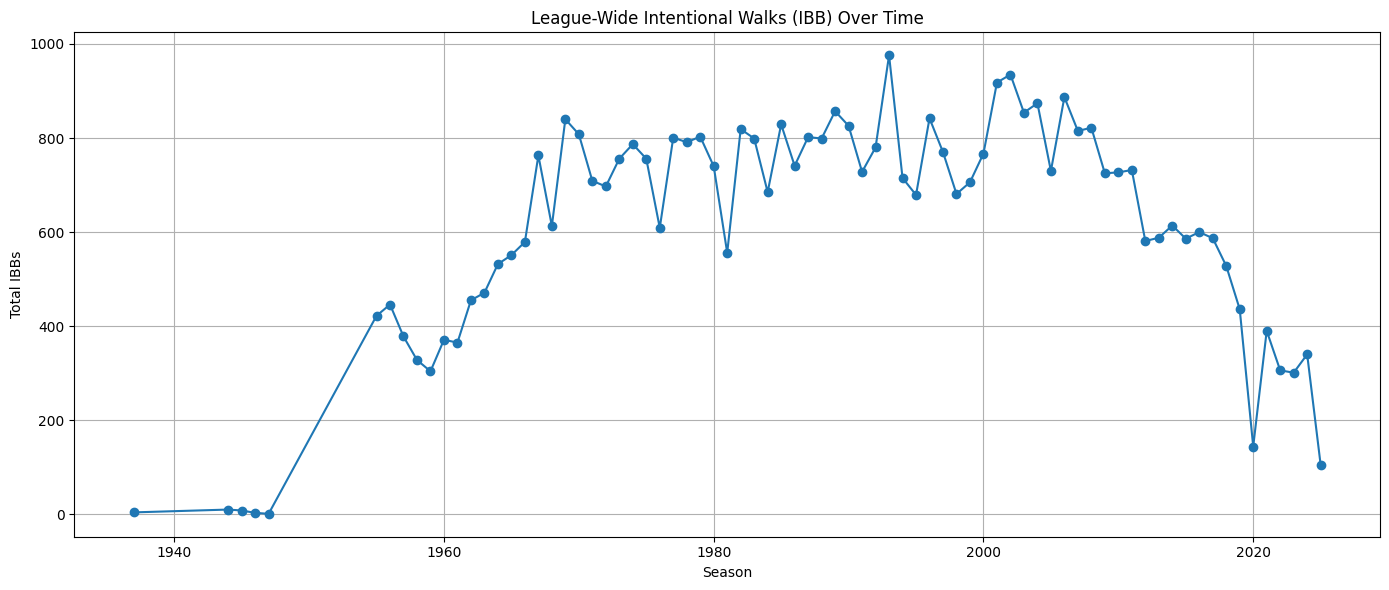

In [ ]:
# Ensure 'Season' and 'IBB' columns are usable
season_data['IBB'] = pd.to_numeric(season_data['IBB'], errors='coerce')
season_data = season_data.dropna(subset=['Season', 'IBB'])

# Group by season and sum IBBs
ibb_trend = season_data.groupby('Season')['IBB'].sum().reset_index()

# Sort by season just in case
ibb_trend = ibb_trend.sort_values(by='Season')

# Plotting the trend
plt.figure(figsize=(14, 6))
plt.plot(ibb_trend['Season'], ibb_trend['IBB'], marker='o', linestyle='-')
plt.title('League-Wide Intentional Walks (IBB) Over Time')
plt.xlabel('Season')
plt.ylabel('Total IBBs')
plt.grid(True)
plt.tight_layout()
plt.show()

Zone Percentage

In [ ]:
print(season_data.head())

             Name  Season  IBB
0  David Eckstein    2001  0.0
1  David Eckstein    2002  0.0
2  David Eckstein    2003  0.0
3  David Eckstein    2004  1.0
4  David Eckstein    2005  0.0


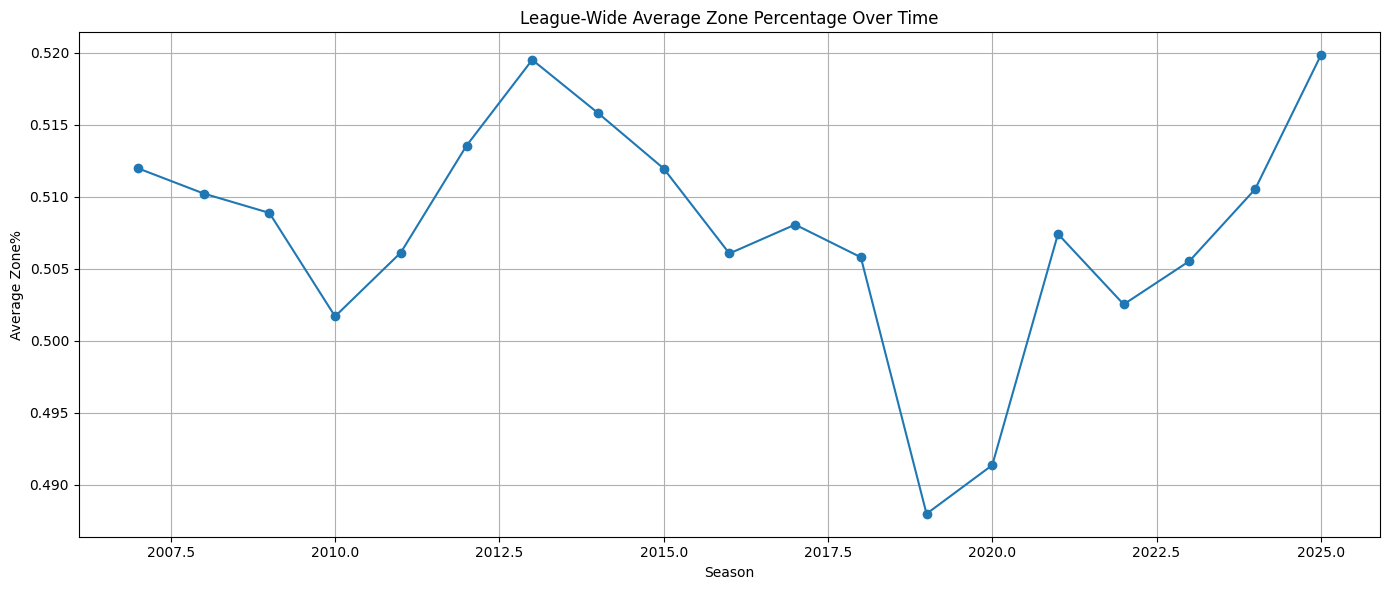

In [ ]:
# Load the data from the correct path
zone_data = pd.read_csv('/content/by season.csv')

# Clean column names
zone_data.columns = zone_data.columns.str.strip()

# Define the column to work with
zone_column = 'Zone% (pi)'

# Ensure 'Zone% (pi)' is numeric
zone_data[zone_column] = pd.to_numeric(zone_data[zone_column], errors='coerce')

# Drop rows with missing Season or Zone%
zone_data_clean = zone_data.dropna(subset=['Season', zone_column])

# Group by season and calculate average Zone%
zone_trend_grouped = zone_data_clean.groupby('Season')[zone_column].mean().reset_index()
zone_trend_grouped = zone_trend_grouped.sort_values(by='Season')

# Plotting the trend
plt.figure(figsize=(14, 6))
plt.plot(zone_trend_grouped['Season'], zone_trend_grouped[zone_column], marker='o', linestyle='-')
plt.title('League-Wide Average Zone Percentage Over Time')
plt.xlabel('Season')
plt.ylabel('Average Zone%')
plt.grid(True)
plt.tight_layout()
plt.show()

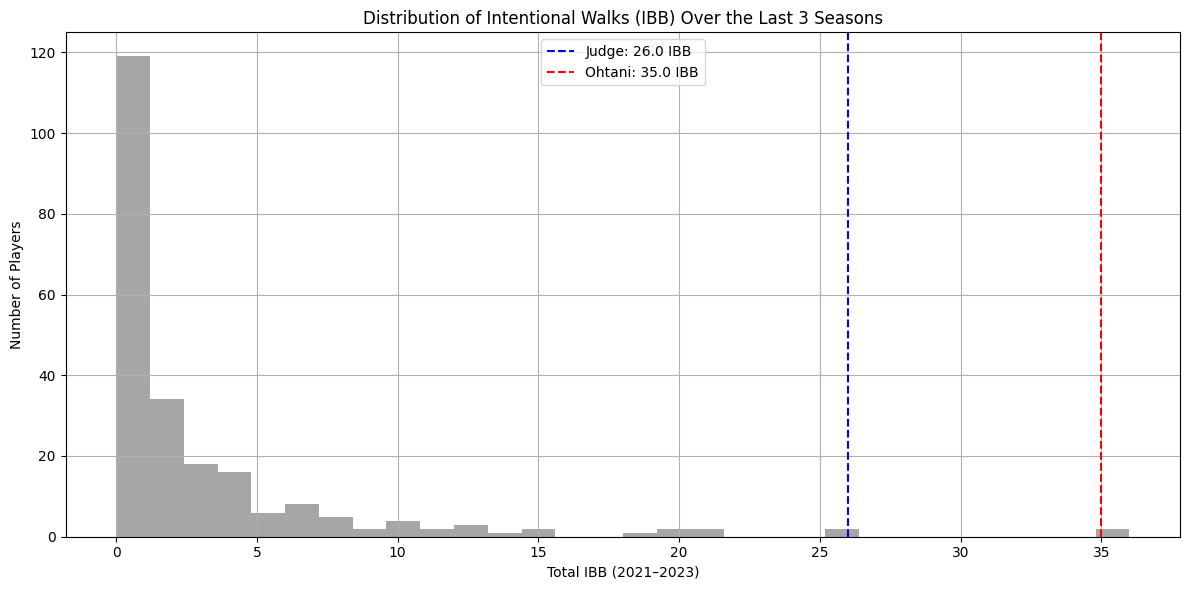

In [ ]:
# Clean column names
zone_data.columns = zone_data.columns.str.strip()

# Make sure column names for players and IBB are correctly referenced
# Adjust these if they are different in your CSV
player_col = 'Name'
season_col = 'Season'
ibb_col = 'IBB'

# Ensure relevant columns are in the correct format
zone_data[season_col] = pd.to_numeric(zone_data[season_col], errors='coerce')
zone_data[ibb_col] = pd.to_numeric(zone_data[ibb_col], errors='coerce')

# Filter data for last 3 seasons (e.g., 2021–2023)
recent_seasons = zone_data[season_col] >= (zone_data[season_col].max() - 2)
recent_data = zone_data[recent_seasons].dropna(subset=[player_col, ibb_col])

# Aggregate IBB per player over the past 3 seasons
ibb_by_player = recent_data.groupby(player_col)[ibb_col].sum().reset_index()

# Get Judge and Ohtani values
judge_ibb = ibb_by_player.loc[ibb_by_player[player_col].str.contains('Judge'), ibb_col].values[0]
ohtani_ibb = ibb_by_player.loc[ibb_by_player[player_col].str.contains('Ohtani'), ibb_col].values[0]

# Plot distribution
plt.figure(figsize=(12, 6))
plt.hist(ibb_by_player[ibb_col], bins=30, alpha=0.7, color='gray')
plt.axvline(judge_ibb, color='blue', linestyle='--', label=f'Judge: {judge_ibb} IBB')
plt.axvline(ohtani_ibb, color='red', linestyle='--', label=f'Ohtani: {ohtani_ibb} IBB')
plt.title('Distribution of Intentional Walks (IBB) Over the Last 3 Seasons')
plt.xlabel('Total IBB (2021–2023)')
plt.ylabel('Number of Players')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

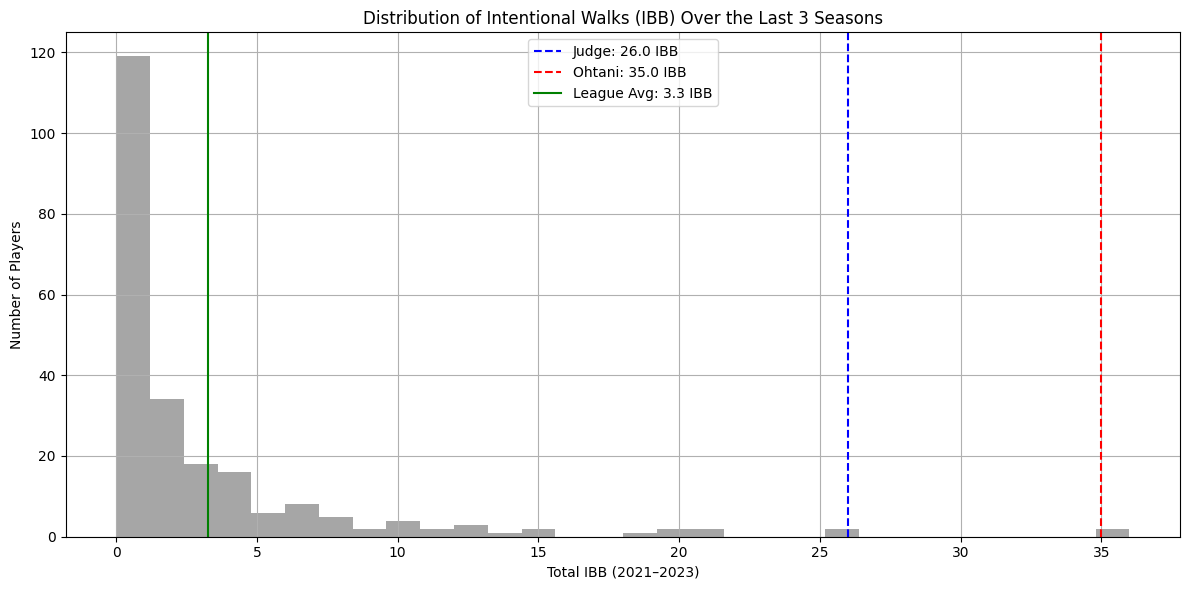

In [ ]:
# Clean column names
zone_data.columns = zone_data.columns.str.strip()

# Make sure column names for players and IBB are correctly referenced
player_col = 'Name'
season_col = 'Season'
ibb_col = 'IBB'

# Ensure relevant columns are in the correct format
zone_data[season_col] = pd.to_numeric(zone_data[season_col], errors='coerce')
zone_data[ibb_col] = pd.to_numeric(zone_data[ibb_col], errors='coerce')

# Filter data for last 3 seasons (e.g., 2021–2023)
recent_seasons = zone_data[season_col] >= (zone_data[season_col].max() - 2)
recent_data = zone_data[recent_seasons].dropna(subset=[player_col, ibb_col])

# Aggregate IBB per player over the past 3 seasons
ibb_by_player = recent_data.groupby(player_col)[ibb_col].sum().reset_index()

# Get IBB totals
judge_ibb = ibb_by_player.loc[ibb_by_player[player_col].str.contains('Judge'), ibb_col].values[0]
ohtani_ibb = ibb_by_player.loc[ibb_by_player[player_col].str.contains('Ohtani'), ibb_col].values[0]

# Calculate league average IBB over the 3 seasons
avg_ibb = ibb_by_player[ibb_col].mean()

# Plot distribution
plt.figure(figsize=(12, 6))
plt.hist(ibb_by_player[ibb_col], bins=30, alpha=0.7, color='gray')
plt.axvline(judge_ibb, color='blue', linestyle='--', label=f'Judge: {judge_ibb} IBB')
plt.axvline(ohtani_ibb, color='red', linestyle='--', label=f'Ohtani: {ohtani_ibb} IBB')
plt.axvline(avg_ibb, color='green', linestyle='-', label=f'League Avg: {avg_ibb:.1f} IBB')
plt.title('Distribution of Intentional Walks (IBB) Over the Last 3 Seasons')
plt.xlabel('Total IBB (2021–2023)')
plt.ylabel('Number of Players')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

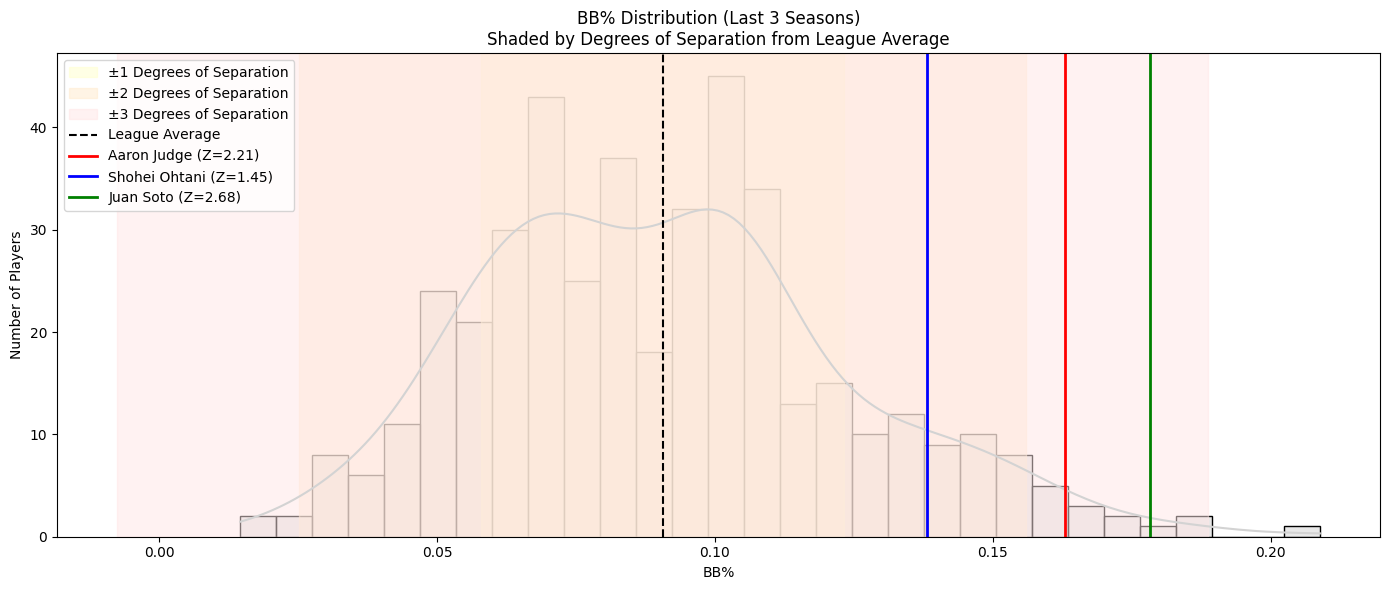

In [ ]:
# Filter for last 3 seasons and clean data
bb_recent = zone_data[zone_data['Season'] >= (zone_data['Season'].max() - 2)]
bb_recent = bb_recent.dropna(subset=['BB%'])
bb_recent['BB%'] = pd.to_numeric(bb_recent['BB%'], errors='coerce')

# Calculate mean and standard deviation
bb_mean = bb_recent['BB%'].mean()
bb_std = bb_recent['BB%'].std()

# Get player BB% values
judge_bb = bb_recent[bb_recent['Name'].str.lower().str.contains('judge')]['BB%'].mean()
ohtani_bb = bb_recent[bb_recent['Name'].str.lower().str.contains('ohtani')]['BB%'].mean()
soto_bb = bb_recent[bb_recent['Name'].str.lower().str.contains('soto')]['BB%'].mean()

# Calculate Z-scores
judge_z = (judge_bb - bb_mean) / bb_std
ohtani_z = (ohtani_bb - bb_mean) / bb_std
soto_z = (soto_bb - bb_mean) / bb_std

# Plot setup
plt.figure(figsize=(14, 6))
sns.histplot(bb_recent['BB%'], bins=30, kde=True, color='lightgray')

# Shaded standard deviation bands
for i, color in zip([1, 2, 3], ['#ffffcc', '#ffebcc', '#ffe6e6']):
    plt.axvspan(bb_mean - i * bb_std, bb_mean + i * bb_std, color=color, alpha=0.5, label=f'±{i} Degrees of Separation')

# League average
plt.axvline(bb_mean, color='black', linestyle='--', linewidth=1.5, label='League Average')

# Player markers
plt.axvline(judge_bb, color='red', linewidth=2, label=f'Aaron Judge (Z={judge_z:.2f})')
plt.axvline(ohtani_bb, color='blue', linewidth=2, label=f'Shohei Ohtani (Z={ohtani_z:.2f})')
plt.axvline(soto_bb, color='green', linewidth=2, label=f'Juan Soto (Z={soto_z:.2f})')

# Title and labels
plt.title('BB% Distribution (Last 3 Seasons)\nShaded by Degrees of Separation from League Average')
plt.xlabel('BB%')
plt.ylabel('Number of Players')
plt.legend()
plt.tight_layout()
plt.show()

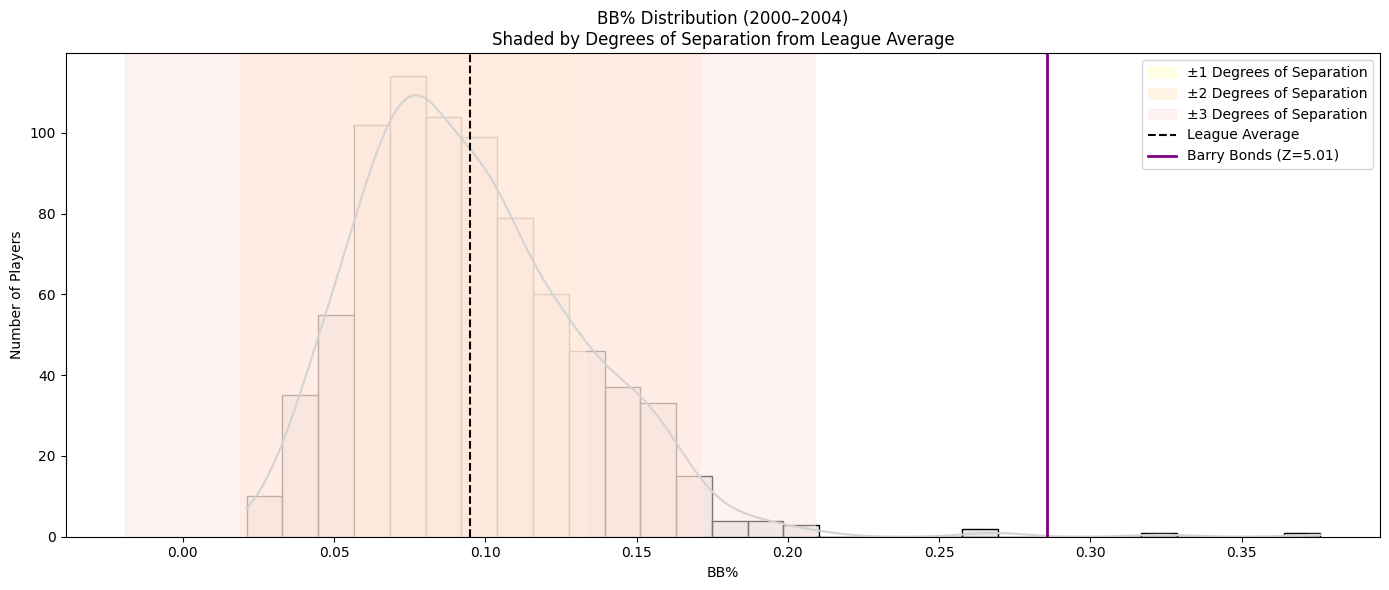

In [ ]:
zone_data.columns = zone_data.columns.str.strip()

# Filter 2000–2004 seasons with valid BB%
bb_2000_2004 = zone_data[(zone_data['Season'] >= 2000) & (zone_data['Season'] <= 2004)]
bb_2000_2004 = bb_2000_2004.dropna(subset=['BB%'])
bb_2000_2004['BB%'] = pd.to_numeric(bb_2000_2004['BB%'], errors='coerce')

# Compute league stats
bb_mean = bb_2000_2004['BB%'].mean()
bb_std = bb_2000_2004['BB%'].std()

# Barry Bonds BB%
bonds_bb = bb_2000_2004[bb_2000_2004['Name'].str.lower().str.contains('bonds')]['BB%'].mean()
bonds_z = (bonds_bb - bb_mean) / bb_std

# Plot
plt.figure(figsize=(14, 6))
sns.histplot(bb_2000_2004['BB%'], bins=30, kde=True, color='lightgray')

# Shaded standard deviation regions
for i, color in zip([1, 2, 3], ['#ffffcc', '#ffebcc', '#ffe6e6']):
    plt.axvspan(bb_mean - i * bb_std, bb_mean + i * bb_std, color=color, alpha=0.5, label=f'±{i} Degrees of Separation')

# League average and Bonds marker
plt.axvline(bb_mean, color='black', linestyle='--', linewidth=1.5, label='League Average')
plt.axvline(bonds_bb, color='purple', linewidth=2, label=f'Barry Bonds (Z={bonds_z:.2f})')

plt.title('BB% Distribution (2000–2004)\nShaded by Degrees of Separation from League Average')
plt.xlabel('BB%')
plt.ylabel('Number of Players')
plt.legend()
plt.tight_layout()
plt.show()

Zone data for Particular players

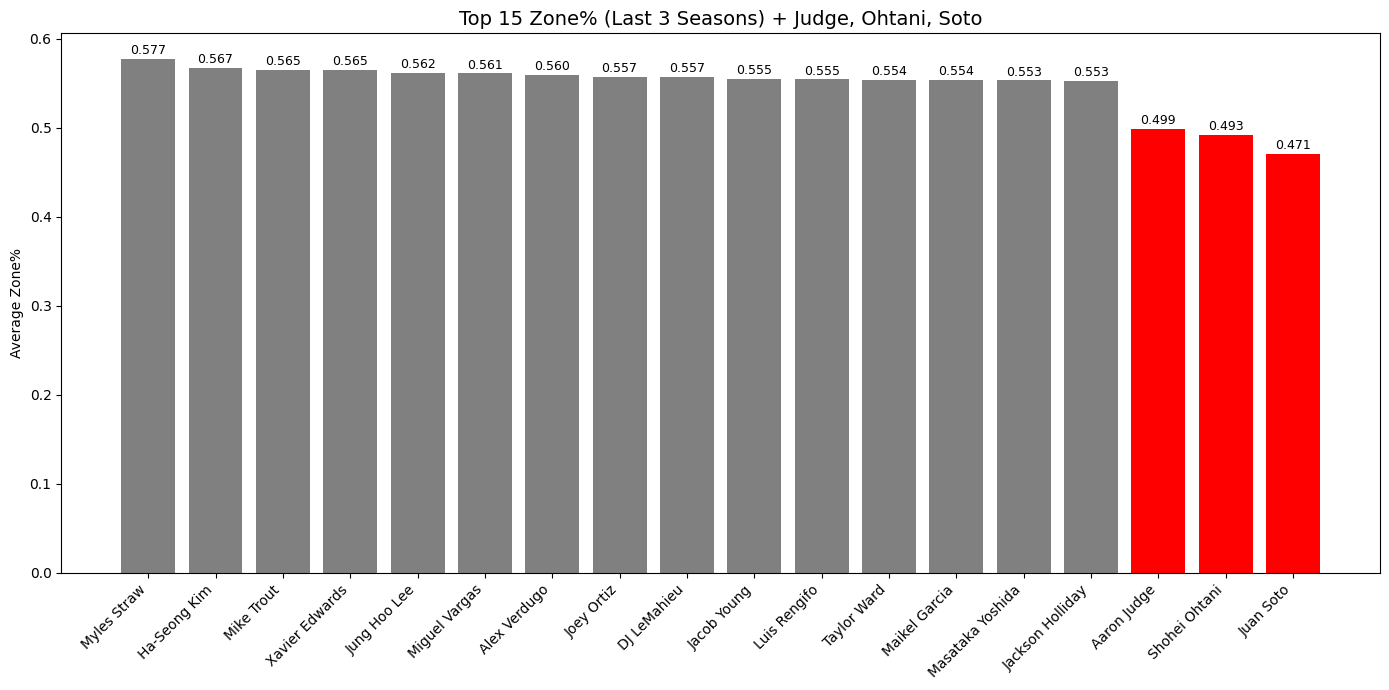

In [ ]:
# Ensure 'Zone% (pi)' and 'Season' are numeric
zone_data['Zone% (pi)'] = pd.to_numeric(zone_data['Zone% (pi)'], errors='coerce')
zone_data['Season'] = pd.to_numeric(zone_data['Season'], errors='coerce')

# Filter for the last 3 seasons
latest_year = zone_data['Season'].max()
zone_data_recent = zone_data[zone_data['Season'] >= latest_year - 2]

# Drop rows without zone percentage
zone_data_recent = zone_data_recent.dropna(subset=['Zone% (pi)'])

# Calculate average Zone% per player across the last 3 years
avg_zone_by_player = zone_data_recent.groupby('Name')['Zone% (pi)'].mean().reset_index()

# Get the top 15 players with the highest average Zone%
top15_zone = avg_zone_by_player.sort_values(by='Zone% (pi)', ascending=False).head(15)

# Also include Judge, Ohtani, and Soto even if they're not in the top 15
target_names = ['aaron judge', 'shohei ohtani', 'juan soto']
target_players = avg_zone_by_player[avg_zone_by_player['Name'].str.lower().isin(target_names)]

# Combine and drop duplicates
combined_players = pd.concat([top15_zone, target_players]).drop_duplicates(subset='Name', keep='first')

# Mark target players for highlighting
combined_players['highlight'] = combined_players['Name'].str.lower().isin(target_names)

# Sort for plotting
combined_players = combined_players.sort_values(by='Zone% (pi)', ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 7))
bars = plt.bar(
    combined_players['Name'],
    combined_players['Zone% (pi)'],
    color=combined_players['highlight'].map({True: 'red', False: 'gray'})
)

plt.title('Top 15 Zone% (Last 3 Seasons) + Judge, Ohtani, Soto', fontsize=14)
plt.ylabel('Average Zone%')
plt.xticks(rotation=45, ha='right')

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

league wide average zone data

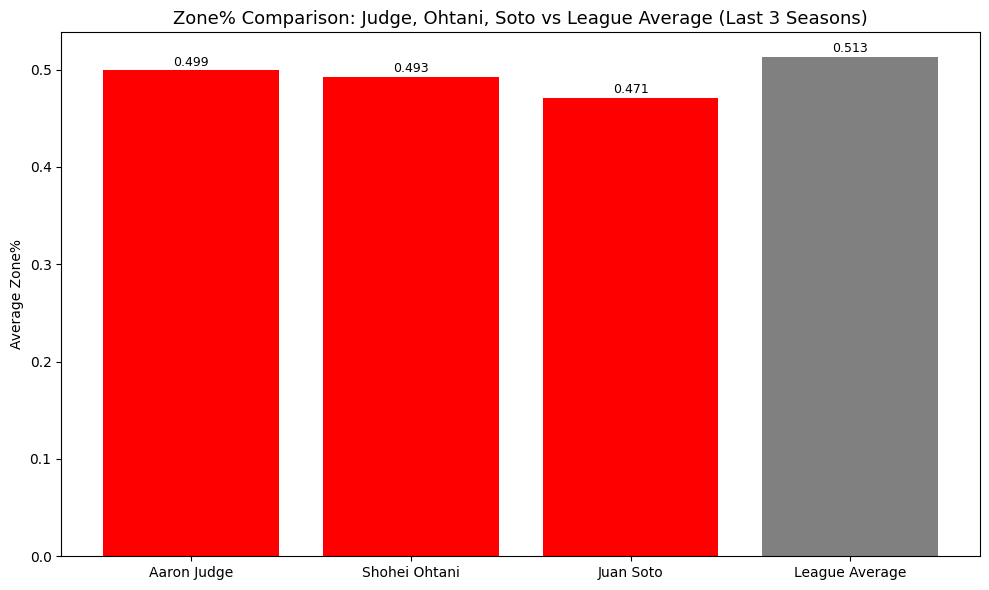

In [ ]:
# Filter for the last 3 seasons
latest_year = zone_data['Season'].max()
zone_data_recent = zone_data[zone_data['Season'] >= latest_year - 2]
zone_data_recent = zone_data_recent.dropna(subset=['Zone% (pi)'])

# Calculate league-wide average Zone%
league_avg_zone = zone_data_recent['Zone% (pi)'].mean()

# Calculate per-player average Zone%
avg_zone_by_player = zone_data_recent.groupby('Name')['Zone% (pi)'].mean().reset_index()

# Select the target players
target_names = ['aaron judge', 'shohei ohtani', 'juan soto']
target_zone = avg_zone_by_player[avg_zone_by_player['Name'].str.lower().isin(target_names)].copy()
target_zone = target_zone.sort_values(by='Zone% (pi)', ascending=False)

# Add league average for comparison
league_row = pd.DataFrame([{'Name': 'League Average', 'Zone% (pi)': league_avg_zone}])
comparison_df = pd.concat([target_zone, league_row], ignore_index=True)

# Mark player bars for highlight
comparison_df['highlight'] = comparison_df['Name'] != 'League Average'

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(
    comparison_df['Name'],
    comparison_df['Zone% (pi)'],
    color=comparison_df['highlight'].map({True: 'red', False: 'gray'})
)

plt.title('Zone% Comparison: Judge, Ohtani, Soto vs League Average (Last 3 Seasons)', fontsize=13)
plt.ylabel('Average Zone%')
plt.xticks(rotation=0)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Degrees of separation

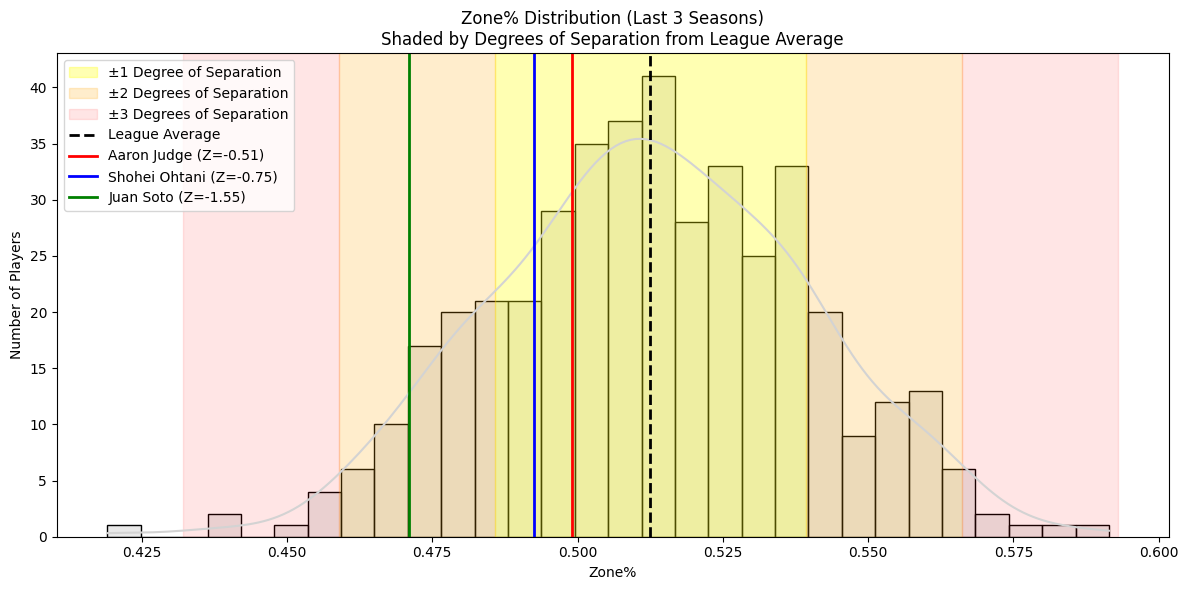

In [ ]:
# Filter for last 3 seasons
latest_year = zone_data['Season'].max()
zone_data_recent = zone_data[zone_data['Season'] >= latest_year - 2].dropna(subset=['Zone% (pi)'])

# Distribution and stats
zone_values = zone_data_recent['Zone% (pi)']
mean_zone = zone_values.mean()
std_zone = zone_values.std()

# Per-player averages
avg_zone_by_player = zone_data_recent.groupby('Name')['Zone% (pi)'].mean().reset_index()

# Target players
target_names = ['aaron judge', 'shohei ohtani', 'juan soto']
player_zones = {
    name: avg_zone_by_player[avg_zone_by_player['Name'].str.lower() == name]['Zone% (pi)'].values[0]
    for name in target_names
}
player_zscores = {name: (val - mean_zone) / std_zone for name, val in player_zones.items()}

# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(zone_values, bins=30, kde=True, color='lightgray', edgecolor='black')

# Shaded regions for degrees of separation
plt.axvspan(mean_zone - std_zone, mean_zone + std_zone, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean_zone - 2 * std_zone, mean_zone - std_zone, color='orange', alpha=0.2, label='±2 Degrees of Separation')
plt.axvspan(mean_zone + std_zone, mean_zone + 2 * std_zone, color='orange', alpha=0.2)
plt.axvspan(mean_zone - 3 * std_zone, mean_zone - 2 * std_zone, color='red', alpha=0.1, label='±3 Degrees of Separation')
plt.axvspan(mean_zone + 2 * std_zone, mean_zone + 3 * std_zone, color='red', alpha=0.1)

# League average line
plt.axvline(mean_zone, color='black', linestyle='--', linewidth=2, label='League Average')

# Player lines
colors = {'aaron judge': 'red', 'shohei ohtani': 'blue', 'juan soto': 'green'}
for name, value in player_zones.items():
    plt.axvline(value, color=colors[name], linestyle='-', linewidth=2,
                label=f"{name.title()} (Z={player_zscores[name]:+.2f})")

# Final labels and legend
plt.title('Zone% Distribution (Last 3 Seasons)\nShaded by Degrees of Separation from League Average')
plt.xlabel('Zone%')
plt.ylabel('Number of Players')
plt.legend()
plt.tight_layout()
plt.show()

## Plate Discipline

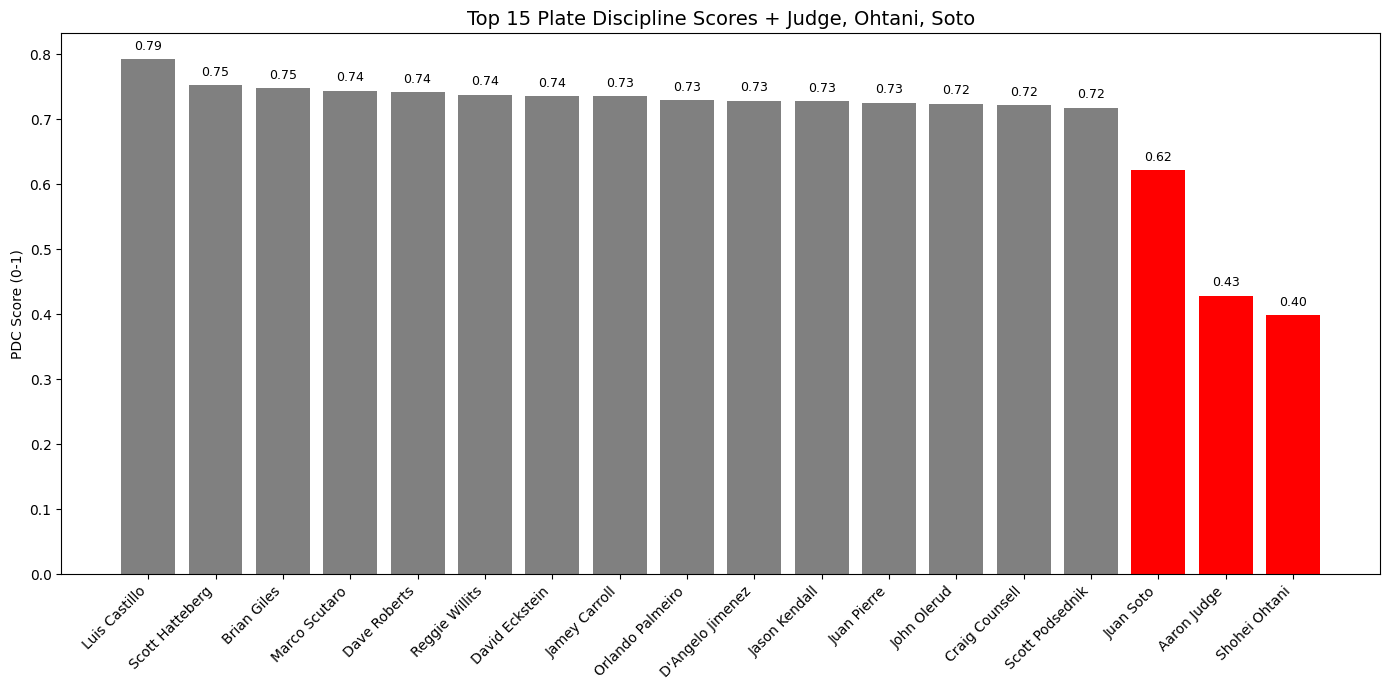

In [ ]:
# Load and clean the dataset
discipline_data = pd.read_csv('/content/career_plate_discipline.csv')
discipline_data.columns = discipline_data.columns.str.strip()

# Define the relevant plate discipline metrics
discipline_metrics = [
    'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
    'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'CStr%', 'CSW%', 'BB%'
]

# Subset and drop missing values
discipline_subset = discipline_data[['Name'] + discipline_metrics].dropna()

# Normalize all metrics 0-1
scaler = MinMaxScaler()
normalized = pd.DataFrame(scaler.fit_transform(discipline_subset[discipline_metrics]), columns=discipline_metrics)

# Invert metrics where lower is better
invert_metrics = ['O-Swing%', 'Z-Swing%', 'Swing%', 'SwStr%', 'F-Strike%', 'CSW%']
normalized[invert_metrics] = 1 - normalized[invert_metrics]

# Calculate Plate Discipline Composite Score (PDC)
discipline_subset['PDC Score'] = normalized.mean(axis=1)

# Add names back
discipline_subset['Name'] = discipline_subset['Name']

# Get top 15 by PDC score
top15_pdc = discipline_subset.sort_values(by='PDC Score', ascending=False).head(15)

# Add Judge, Ohtani, Soto if not in top 15
comparison_names = ['aaron judge', 'shohei ohtani', 'juan soto']
comparison_players = discipline_subset[discipline_subset['Name'].str.lower().isin(comparison_names)]

# Combine and deduplicate
combined_pdc = pd.concat([top15_pdc, comparison_players]).drop_duplicates(subset='Name')
combined_pdc['highlight'] = combined_pdc['Name'].str.lower().isin(comparison_names)

# Sort for display
combined_pdc = combined_pdc.sort_values(by='PDC Score', ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 7))
bars = plt.bar(combined_pdc['Name'], combined_pdc['PDC Score'],
               color=combined_pdc['highlight'].map({True: 'red', False: 'gray'}))

plt.title('Top 15 Plate Discipline Scores + Judge, Ohtani, Soto', fontsize=14)
plt.ylabel('PDC Score (0-1)')
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

This chart ranks hitters by a custom-built Plate Discipline Composite (PDC) Score, which aggregates multiple advanced plate discipline metrics into a single 0–1 score.

🔧 How the PDC Score Was Built:
We used the following stats:

Lower is better (inverted):
O-Swing%, Z-Swing%, Swing%, SwStr%, F-Strike%, CSW%

Higher is better:
O-Contact%, Z-Contact%, Contact%, CStr%, BB%, Zone%

Steps:

Normalize each stat to a 0–1 scale.

Invert the ones where a lower value means better discipline.

Average all stats to get the final PDC Score.

This creates a holistic measure of how well a player controls the strike zone — not just by walks, but by swing decisions, contact quality, and zone judgment.

Then, we:

Ranked players by PDC Score.

Appended Aaron Judge, Shohei Ohtani, and Juan Soto even if they weren’t top 15.

Highlighted them in red for comparison.



In [ ]:

# Utility to remove accents
def normalize_name(name):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', name)
        if not unicodedata.combining(c)
    ).lower().strip()

# Normalize the name column in your dataset
discipline_subset['name_normalized'] = discipline_subset['Name'].apply(normalize_name)

# Define players to highlight
comparison_names = ['aaron judge', 'shohei ohtani', 'juan soto', 'joey votto', 'javier baez']
colors = {
    'aaron judge': 'red',
    'shohei ohtani': 'blue',
    'juan soto': 'green',
    'joey votto': 'purple',
    'javier baez': 'brown'
}

# Extract scores safely using normalized names
target_scores = {}
missing_players = []
for name in comparison_names:
    row = discipline_subset[discipline_subset['name_normalized'] == normalize_name(name)]
    if not row.empty:
        target_scores[name] = row['PDC Score'].values[0]
    else:
        missing_players.append(name)

# Warn if any players were not found
if missing_players:
    print("⚠️ These players were not found in the dataset:", missing_players)


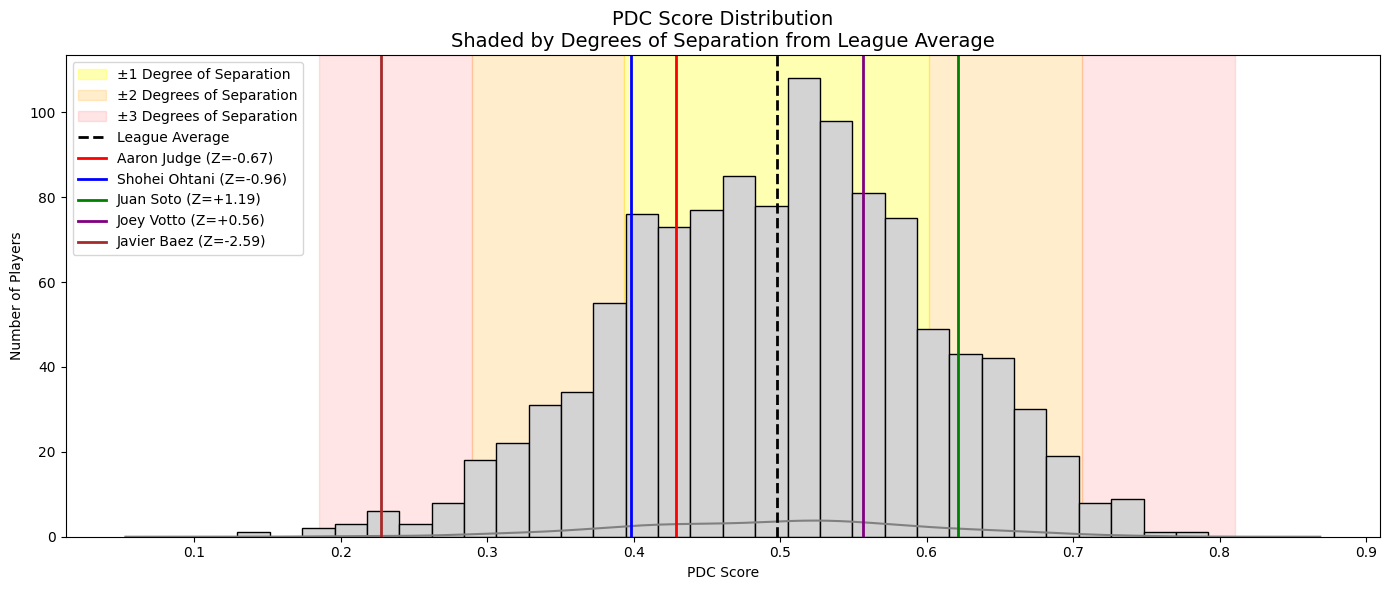

In [ ]:

# Define plate discipline metrics
discipline_metrics = [
    'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
    'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'CStr%', 'CSW%', 'BB%'
]

# Normalize helper
def normalize_name(name):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', name)
        if not unicodedata.combining(c)
    ).lower().strip()

# Subset, drop missing values, normalize metrics
discipline_subset = discipline_data[['Name'] + discipline_metrics].dropna()
scaler = MinMaxScaler()
normalized = pd.DataFrame(scaler.fit_transform(discipline_subset[discipline_metrics]), columns=discipline_metrics)

# Invert metrics where lower is better
invert_metrics = ['O-Swing%', 'Z-Swing%', 'Swing%', 'SwStr%', 'F-Strike%', 'CSW%']
normalized[invert_metrics] = 1 - normalized[invert_metrics]

# Compute PDC score and add normalized name column
discipline_subset['PDC Score'] = normalized.mean(axis=1)
discipline_subset['name_normalized'] = discipline_subset['Name'].apply(normalize_name)

# Extract PDC stats
pdc_scores = discipline_subset['PDC Score']
mean = pdc_scores.mean()
std = pdc_scores.std()

# Players to highlight
comparison_names = ['aaron judge', 'shohei ohtani', 'juan soto', 'joey votto', 'javier baez']
colors = {
    'aaron judge': 'red',
    'shohei ohtani': 'blue',
    'juan soto': 'green',
    'joey votto': 'purple',
    'javier baez': 'brown'
}

# Match players with normalized names
target_scores = {}
missing_players = []
for name in comparison_names:
    norm = normalize_name(name)
    row = discipline_subset[discipline_subset['name_normalized'] == norm]
    if not row.empty:
        target_scores[name] = row['PDC Score'].values[0]
    else:
        missing_players.append(name)

if missing_players:
    print("⚠️ These players were not found in the dataset:", missing_players)

# Plotting
plt.figure(figsize=(14, 6))
hist_vals, bin_edges, _ = plt.hist(pdc_scores, bins=30, edgecolor='black', color='white', alpha=0.0)

# Shaded separation zones
plt.axvspan(mean - std, mean + std, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.2, label='±2 Degrees of Separation')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.2)
plt.axvspan(mean - 3*std, mean - 2*std, color='red', alpha=0.1, label='±3 Degrees of Separation')
plt.axvspan(mean + 2*std, mean + 3*std, color='red', alpha=0.1)

# Histogram + KDE
plt.hist(pdc_scores, bins=bin_edges, edgecolor='black', color='lightgray', alpha=1)
sns.kdeplot(pdc_scores, color='gray', linewidth=1.5)

# League average
plt.axvline(mean, color='black', linestyle='--', linewidth=2, label='League Average')

# Vertical lines for target players
for name, score in target_scores.items():
    z = (score - mean) / std
    plt.axvline(score, color=colors[name], linestyle='-', linewidth=2, label=f"{name.title()} (Z={z:+.2f})")

# Final formatting
plt.title('PDC Score Distribution\nShaded by Degrees of Separation from League Average', fontsize=14)
plt.xlabel('PDC Score')
plt.ylabel('Number of Players')
plt.legend()
plt.tight_layout()
plt.show()

out of zone swing percentage

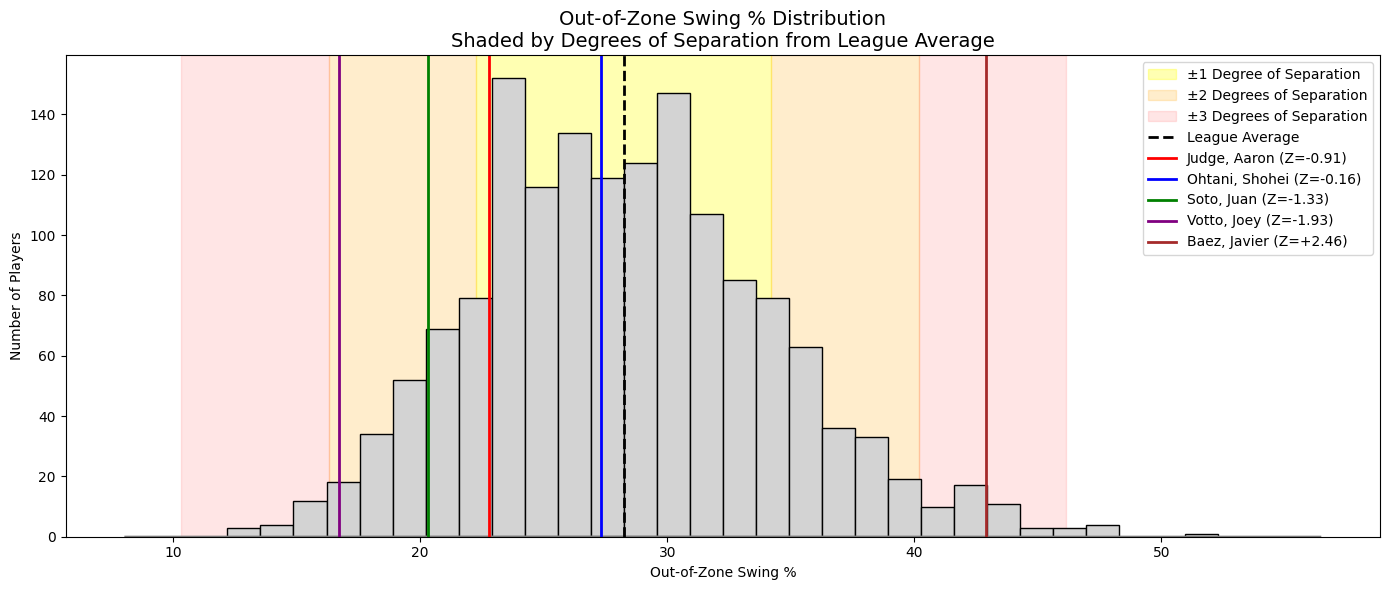

In [ ]:
# Load and prepare data
savant_data = pd.read_csv('/content/savant_stats.csv')
savant_data.columns = savant_data.columns.str.strip()

# Normalize name utility
def normalize_name(name):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', name)
        if not unicodedata.combining(c)
    ).lower().strip()

# Normalize names in the dataset
savant_data['name_normalized'] = savant_data['last_name, first_name'].apply(normalize_name)

# Extract and clean correct column name for out-of-zone swing PERCENT
savant_data['oz_swing_percent'] = pd.to_numeric(savant_data['oz_swing_percent'], errors='coerce')
oz_swing = savant_data['oz_swing_percent'].dropna()
mean = oz_swing.mean()
std = oz_swing.std()

# Players and highlight colors
comparison_names_formatted = ['Judge, Aaron', 'Ohtani, Shohei', 'Soto, Juan', 'Votto, Joey', 'Baez, Javier']
colors = {
    'Judge, Aaron': 'red',
    'Ohtani, Shohei': 'blue',
    'Soto, Juan': 'green',
    'Votto, Joey': 'purple',
    'Baez, Javier': 'brown'
}

# Match scores
target_scores = {}
missing_players = []
for name in comparison_names_formatted:
    norm_name = normalize_name(name)
    match = savant_data[savant_data['name_normalized'] == norm_name]
    if not match.empty:
        target_scores[name] = match.iloc[0]['oz_swing_percent']
    else:
        missing_players.append(name)

if missing_players:
    print("⚠️ Missing players from dataset:", missing_players)

# Plotting
plt.figure(figsize=(14, 6))
hist_vals, bin_edges, _ = plt.hist(oz_swing, bins=30, edgecolor='black', color='white', alpha=0.0)

# Shaded standard deviation bands
plt.axvspan(mean - std, mean + std, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.2, label='±2 Degrees of Separation')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.2)
plt.axvspan(mean - 3*std, mean - 2*std, color='red', alpha=0.1, label='±3 Degrees of Separation')
plt.axvspan(mean + 2*std, mean + 3*std, color='red', alpha=0.1)

# Histogram and KDE
plt.hist(oz_swing, bins=bin_edges, edgecolor='black', color='lightgray', alpha=1)
sns.kdeplot(oz_swing, color='gray', linewidth=1.5)

# League average line
plt.axvline(mean, color='black', linestyle='--', linewidth=2, label='League Average')

# Player markers with Z-scores
for name, score in target_scores.items():
    z = (score - mean) / std
    plt.axvline(score, color=colors[name], linestyle='-', linewidth=2, label=f"{name} (Z={z:+.2f})")

# Final touches
plt.title('Out-of-Zone Swing % Distribution\nShaded by Degrees of Separation from League Average', fontsize=14)
plt.xlabel('Out-of-Zone Swing %')
plt.ylabel('Number of Players')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
## Relation between zone percentage and oz swing percentage

In [ ]:
# Ensure both columns are numeric
savant_data['oz_swing_percent'] = pd.to_numeric(savant_data['oz_swing_percent'], errors='coerce')
savant_data['in_zone_percent'] = pd.to_numeric(savant_data['in_zone_percent'], errors='coerce')

# Drop rows with missing values in either column
regression_data = savant_data.dropna(subset=['oz_swing_percent', 'in_zone_percent'])

# Define predictor and response
X = sm.add_constant(regression_data['oz_swing_percent'])  # add intercept
y = regression_data['in_zone_percent']

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        in_zone_percent   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     183.0
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.84e-39
Time:                        18:53:35   Log-Likelihood:                -3515.2
No. Observations:                1534   AIC:                             7034.
Df Residuals:                    1532   BIC:                             7045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               52.0997      0.296  

### Zone Grid

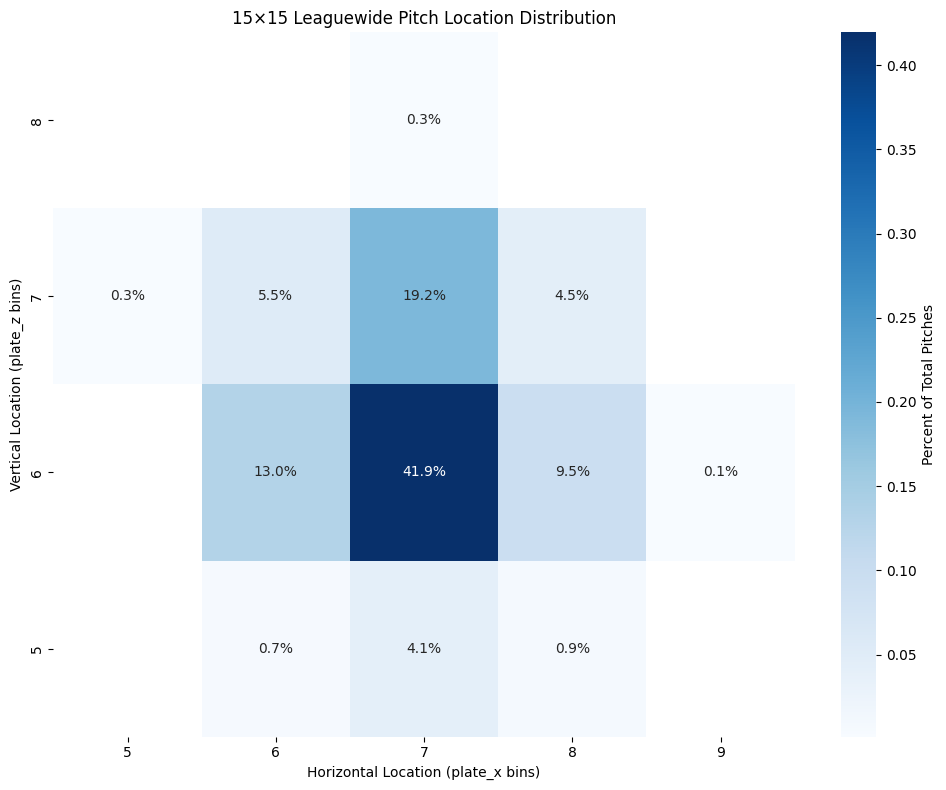

In [ ]:
# Load and clean data
location_data = pd.read_csv('/content/location data.csv')
location_data.columns = location_data.columns.str.strip()

# Drop rows with missing location
zone_data = location_data.dropna(subset=['plate_x', 'plate_z'])

# Define 15×15 bin edges
x_bins = np.linspace(-1.5, 1.5, 16)
z_bins = np.linspace(1.0, 4.0, 16)

# Assign bins
zone_data['x_bin'] = pd.cut(zone_data['plate_x'], bins=x_bins, labels=False)
zone_data['z_bin'] = pd.cut(zone_data['plate_z'], bins=z_bins, labels=False)

# Count pitches per bin
grouped = zone_data.groupby(['z_bin', 'x_bin']).size().reset_index(name='pitch_count')

# Calculate total pitches and percent per bin
total_pitches = grouped['pitch_count'].sum()
grouped['pitch_percent'] = grouped['pitch_count'] / total_pitches

# Pivot to grid format
heatmap_data = grouped.pivot(index='z_bin', columns='x_bin', values='pitch_percent')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data[::-1],  # Flip for proper top-to-bottom zone orientation
    annot=True,
    fmt=".1%",
    cmap="Blues",
    cbar_kws={'label': 'Percent of Total Pitches'}
)

plt.title("15×15 Leaguewide Pitch Location Distribution")
plt.xlabel("Horizontal Location (plate_x bins)")
plt.ylabel("Vertical Location (plate_z bins)")
plt.tight_layout()
plt.show()

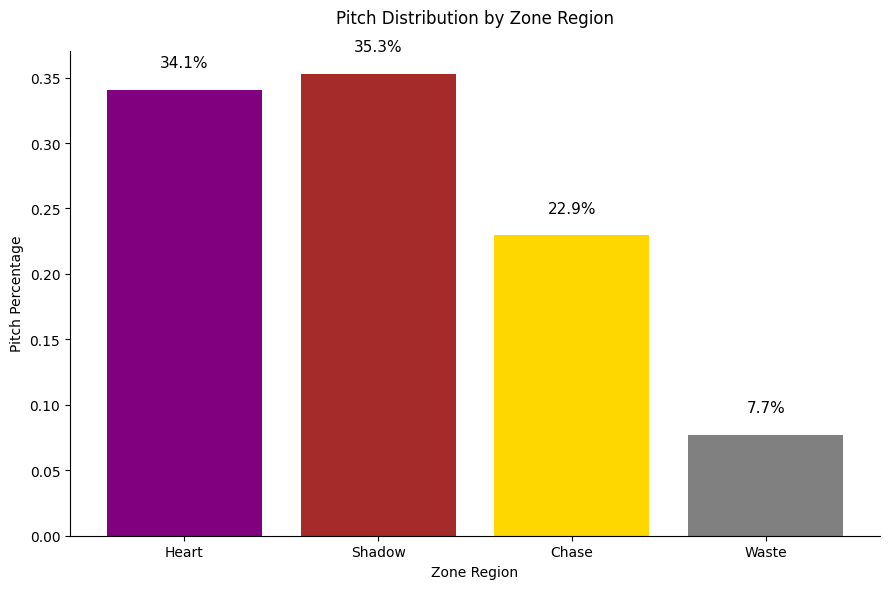

In [ ]:
true_location = pd.read_csv("/content/true_zone.csv")
true_location.columns = true_location.columns.str.strip()

# Calculate pitch distribution
zone_breakdown = true_location['zone'].value_counts(normalize=True).sort_index().reset_index()
zone_breakdown.columns = ['zone', 'pitch_percent']

# Plot
plt.figure(figsize=(9, 6))
bars = plt.bar(
    zone_breakdown['zone'].astype(str),
    zone_breakdown['pitch_percent'],
    color=['purple', 'brown', 'gold', 'gray']
)

# Add % labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.015,
        f'{height:.1%}',
        ha='center',
        va='bottom',
        fontsize=11
    )

# Clean axis styling
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and formatting
plt.title("Pitch Distribution by Zone Region", pad=20)
plt.xlabel("Zone Region")
plt.ylabel("Pitch Percentage")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Heart", "Shadow", "Chase", "Waste"])
plt.grid(False)
plt.tight_layout()
plt.show()

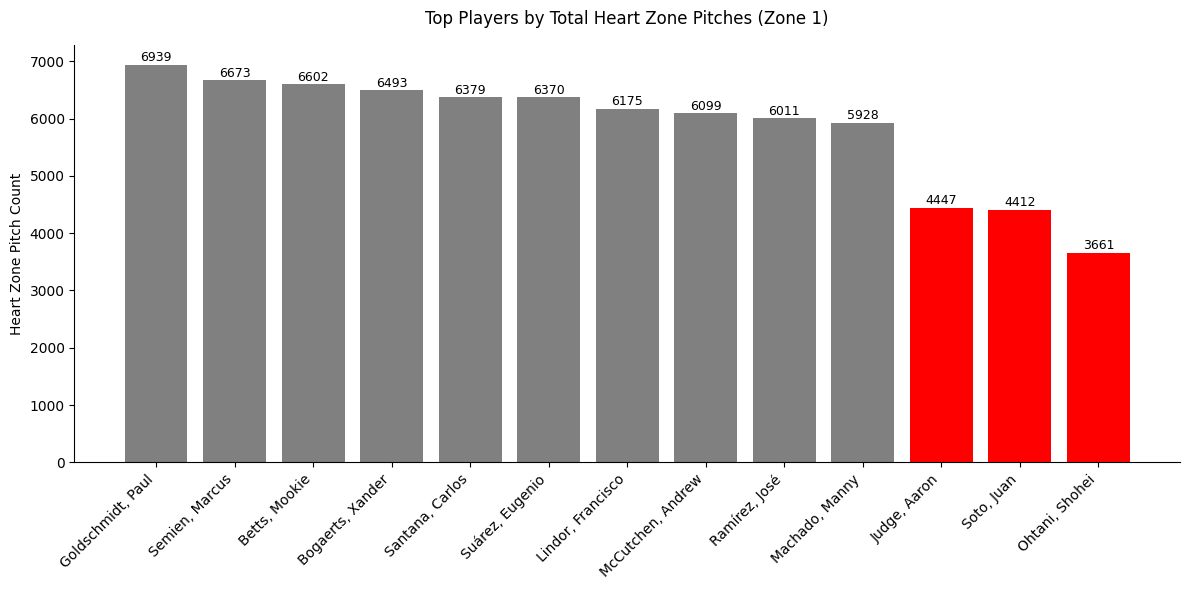

In [ ]:
# Filter for Heart zone (zone == 1) and sum 'pitches' per player
heart_pitch_totals = true_location[true_location['zone'] == 1].groupby('player_name')['pitches'].sum().reset_index()
heart_pitch_totals = heart_pitch_totals.sort_values(by='pitches', ascending=False)

# Define comparison players (names must match exactly as in the dataset)
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']

# Get comparison players even if not in top 10
comparison_rows = heart_pitch_totals[heart_pitch_totals['player_name'].isin(comparison_names)]

# Combine top 10 with comparison players, removing any duplicates
combined = pd.concat([heart_pitch_totals.head(10), comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)

# Sort for plotting
combined = combined.sort_values(by='pitches', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['pitches'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Annotate pitch counts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

# Styling
plt.title("Top Players by Total Heart Zone Pitches (Zone 1)", pad=15)
plt.ylabel("Heart Zone Pitch Count")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

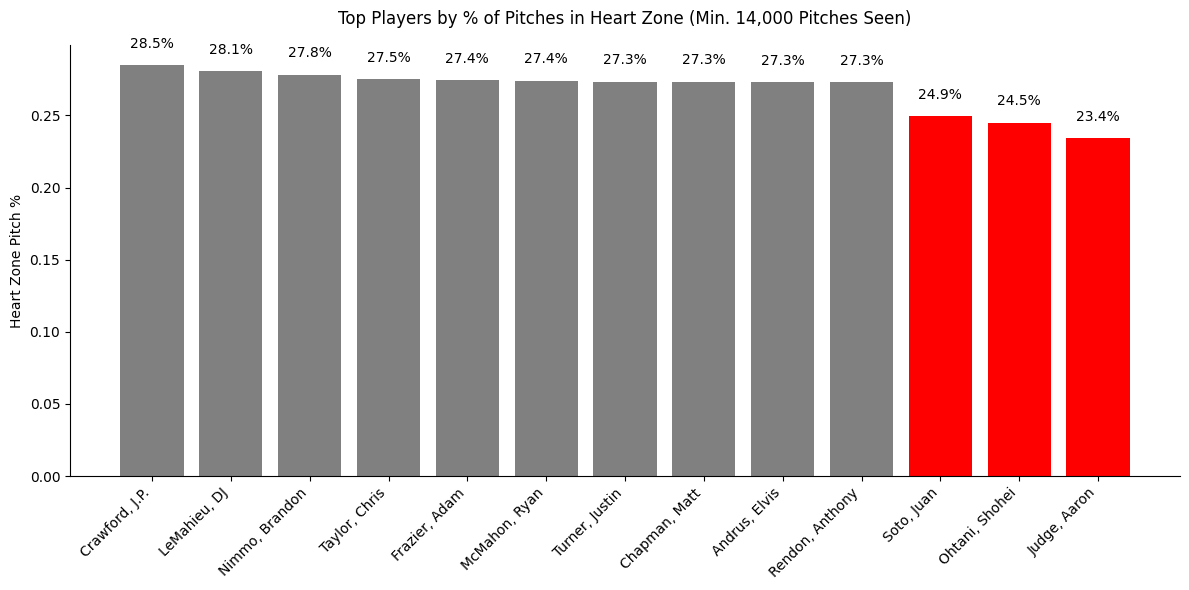

In [ ]:
# Total pitches per player (all zones)
total_pitches_by_player = true_location.groupby('player_name')['pitches'].sum().reset_index()
total_pitches_by_player.columns = ['player_name', 'total_pitches']

# Filter to players with 15,000+ total pitches
total_pitches_by_player = total_pitches_by_player[total_pitches_by_player['total_pitches'] >= 14000]

# Heart zone pitches
heart_pitches_by_player = true_location[true_location['zone'] == 1].groupby('player_name')['pitches'].sum().reset_index()
heart_pitches_by_player.columns = ['player_name', 'heart_pitches']

# Merge and calculate pitch percent
merged = pd.merge(heart_pitches_by_player, total_pitches_by_player, on='player_name')
merged['pitch_percent'] = merged['heart_pitches'] / merged['total_pitches']

# Top 10 by pitch_percent
top_10_percent = merged.sort_values(by='pitch_percent', ascending=False).head(10)

# Ensure comparison players are included
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_rows = merged[merged['player_name'].isin(comparison_names)]

# Combine and deduplicate
combined = pd.concat([top_10_percent, comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)

# Sort for plotting
combined = combined.sort_values(by='pitch_percent', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['pitch_percent'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height:.1%}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Style cleanup
plt.title("Top Players by % of Pitches in Heart Zone (Min. 14,000 Pitches Seen)", pad=15)
plt.ylabel("Heart Zone Pitch %")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Clean axis borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

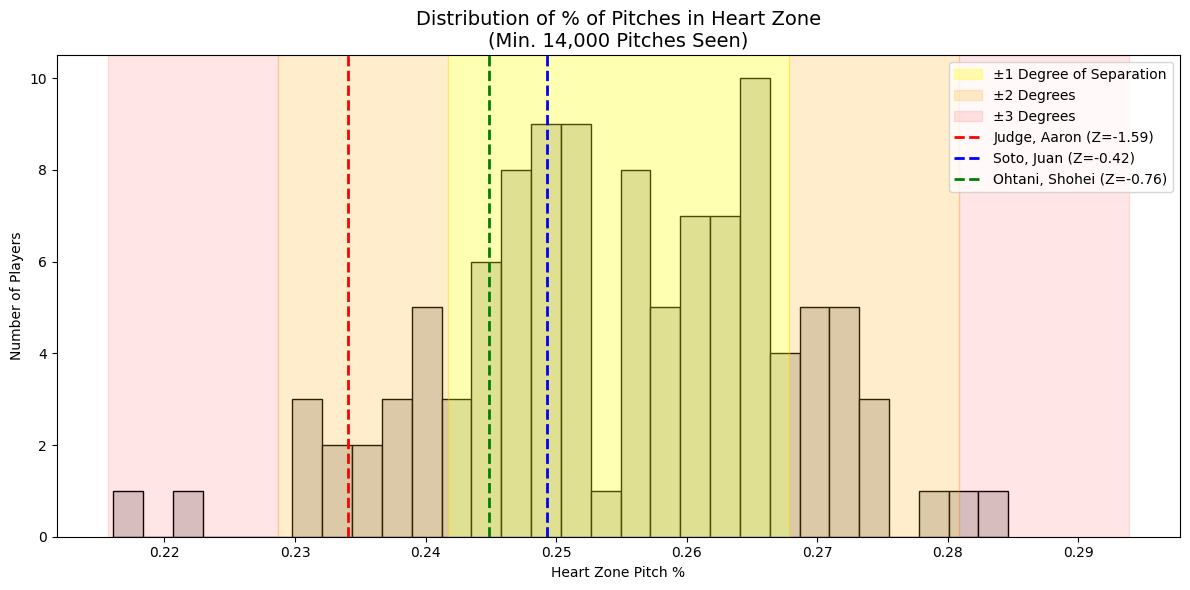

In [ ]:
# Total and Heart zone pitches
total_pitches = true_location.groupby('player_name')['pitches'].sum().reset_index()
total_pitches.columns = ['player_name', 'total_pitches']

heart_pitches = true_location[true_location['zone'] == 1].groupby('player_name')['pitches'].sum().reset_index()
heart_pitches.columns = ['player_name', 'heart_pitches']

# Filter eligible players (min 14,000 pitches OR target comparisons)
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
eligible = total_pitches[
    (total_pitches['total_pitches'] >= 14000) |
    (total_pitches['player_name'].isin(comparison_names))
]

# Merge and calculate percentage
merged = pd.merge(heart_pitches, eligible, on='player_name')
merged['pitch_percent'] = merged['heart_pitches'] / merged['total_pitches']

# Stats for degrees of separation
mean = merged['pitch_percent'].mean()
std = merged['pitch_percent'].std()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(merged['pitch_percent'], bins=30, color='lightgray', edgecolor='black')

# Shaded standard deviation zones
plt.axvspan(mean - std, mean + std, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.2, label='±2 Degrees')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.2)
plt.axvspan(mean - 3*std, mean - 2*std, color='red', alpha=0.1, label='±3 Degrees')
plt.axvspan(mean + 2*std, mean + 3*std, color='red', alpha=0.1)

# Mark comparison players
colors = {
    'Judge, Aaron': 'red',
    'Soto, Juan': 'blue',
    'Ohtani, Shohei': 'green'
}
for name in comparison_names:
    row = merged[merged['player_name'] == name]
    if not row.empty:
        val = row['pitch_percent'].values[0]
        z = (val - mean) / std
        plt.axvline(x=val, color=colors[name], linestyle='--', linewidth=2,
                    label=f"{name} (Z={z:+.2f})")

# Formatting
plt.title("Distribution of % of Pitches in Heart Zone\n(Min. 14,000 Pitches Seen)", fontsize=14)
plt.xlabel("Heart Zone Pitch %")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

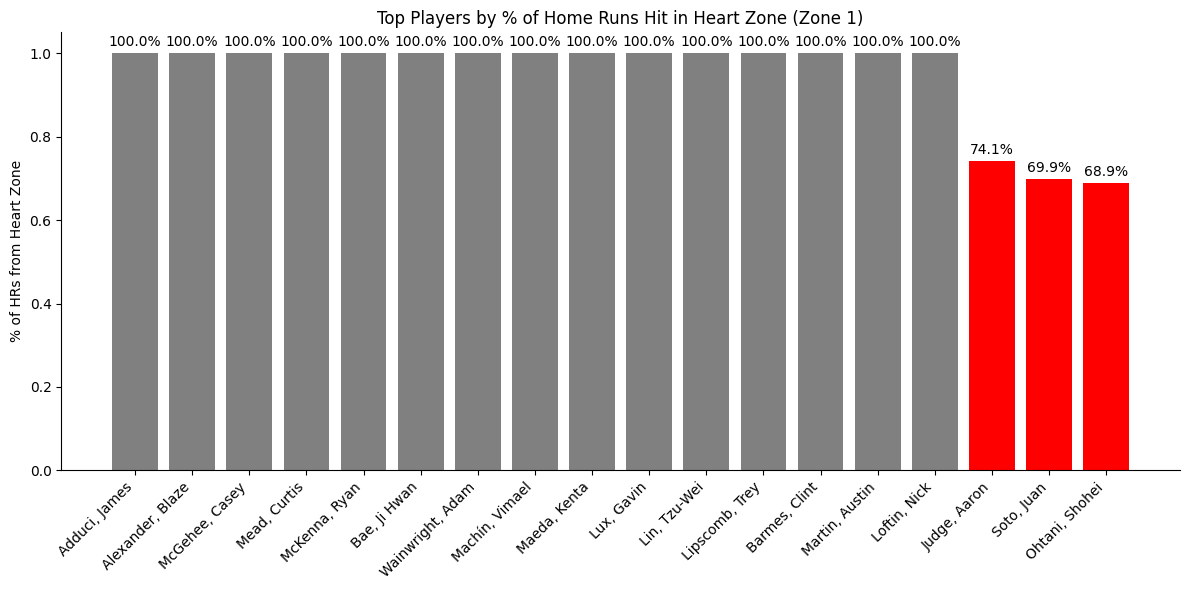

In [ ]:
# Total HRs per player in Heart zone
heart_hr_count = true_location[true_location['zone'] == 1].groupby('player_name')['hrs'].sum().reset_index()
heart_hr_count.columns = ['player_name', 'heart_hrs']

# Total HRs across all zones
all_hr_count = true_location.groupby('player_name')['hrs'].sum().reset_index()
all_hr_count.columns = ['player_name', 'total_hrs']

# Merge and calculate percentage
hr_percent = pd.merge(heart_hr_count, all_hr_count, on='player_name')
hr_percent['percent_heart_hr'] = hr_percent['heart_hrs'] / hr_percent['total_hrs']

# Get top 15 by heart HR %
top15_hr_heart = hr_percent.sort_values(by='percent_heart_hr', ascending=False).head(15)

# Add comparison players
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_rows = hr_percent[hr_percent['player_name'].isin(comparison_names)]

# Combine and flag highlights
combined = pd.concat([top15_hr_heart, comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)

# Sort for display
combined = combined.sort_values(by='percent_heart_hr', ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['percent_heart_hr'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

# Style
plt.title("Top Players by % of Home Runs Hit in Heart Zone (Zone 1)")
plt.ylabel("% of HRs from Heart Zone")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Clean up borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

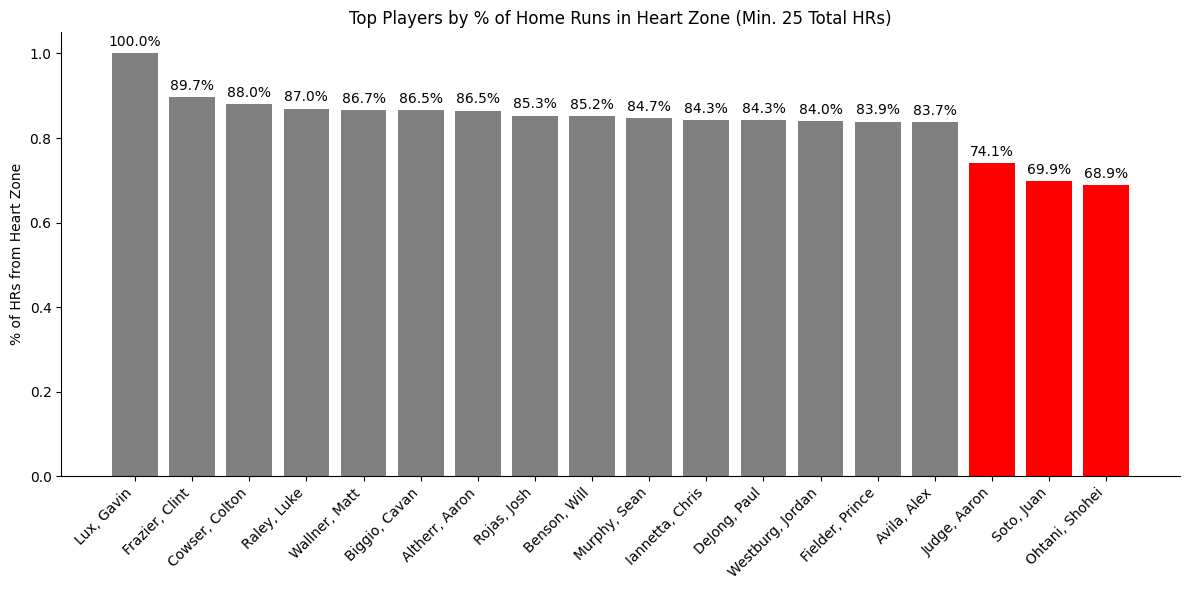

In [ ]:
# Total HRs per player in Heart zone
heart_hr_count = true_location[true_location['zone'] == 1].groupby('player_name')['hrs'].sum().reset_index()
heart_hr_count.columns = ['player_name', 'heart_hrs']

# Total HRs across all zones
all_hr_count = true_location.groupby('player_name')['hrs'].sum().reset_index()
all_hr_count.columns = ['player_name', 'total_hrs']

# Merge and calculate percentage
hr_percent = pd.merge(heart_hr_count, all_hr_count, on='player_name')

# Filter out players with fewer than 12 total HRs
hr_percent = hr_percent[hr_percent['total_hrs'] >= 25]

# Compute percentage
hr_percent['percent_heart_hr'] = hr_percent['heart_hrs'] / hr_percent['total_hrs']

# Get top 15 by heart HR %
top15_hr_heart = hr_percent.sort_values(by='percent_heart_hr', ascending=False).head(15)

# Add comparison players
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_rows = hr_percent[hr_percent['player_name'].isin(comparison_names)]

# Combine and highlight
combined = pd.concat([top15_hr_heart, comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)

# Sort for display
combined = combined.sort_values(by='percent_heart_hr', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['percent_heart_hr'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

# Styling
plt.title("Top Players by % of Home Runs in Heart Zone (Min. 25 Total HRs)")
plt.ylabel("% of HRs from Heart Zone")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Clean plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

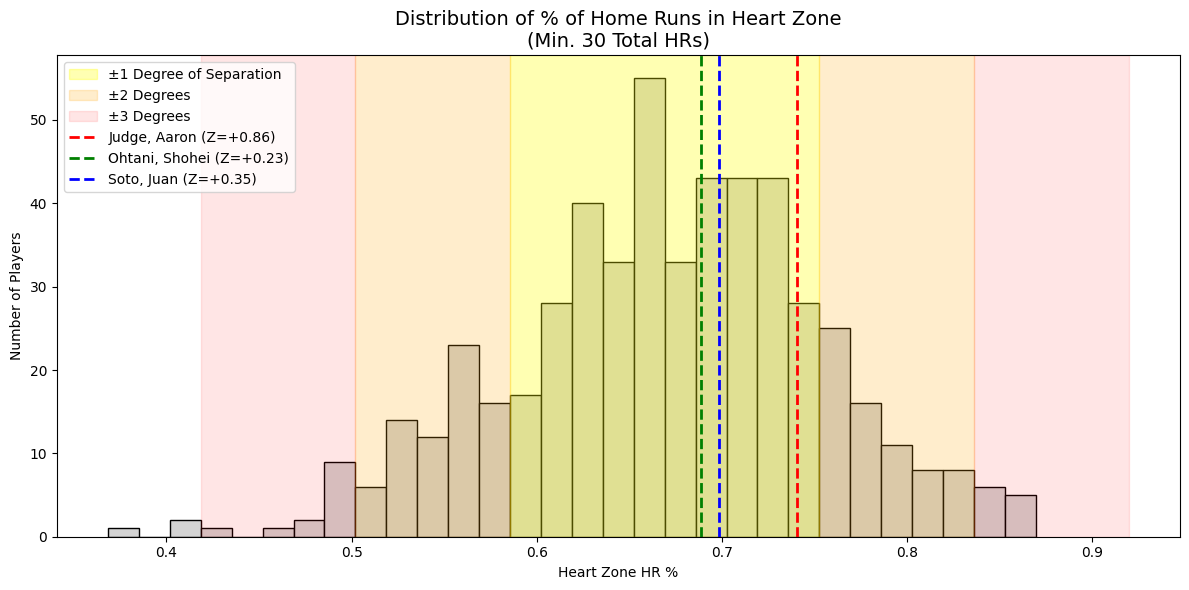

In [ ]:
# Total HRs in Heart zone (zone == 1)
heart_hr_count = true_location[true_location['zone'] == 1].groupby('player_name')['hrs'].sum().reset_index()
heart_hr_count.columns = ['player_name', 'heart_hrs']

# Total HRs across all zones
all_hr_count = true_location.groupby('player_name')['hrs'].sum().reset_index()
all_hr_count.columns = ['player_name', 'total_hrs']

# Merge and filter by minimum 30 total HRs
hr_percent = pd.merge(heart_hr_count, all_hr_count, on='player_name')
hr_percent = hr_percent[hr_percent['total_hrs'] >= 30]

# Calculate percentage of HRs from Heart zone
hr_percent['percent_heart_hr'] = hr_percent['heart_hrs'] / hr_percent['total_hrs']

# Data for Judge, Soto, Ohtani
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_scores = hr_percent[hr_percent['player_name'].isin(comparison_names)]

# Calculate mean and std for degrees of separation
mean = hr_percent['percent_heart_hr'].mean()
std = hr_percent['percent_heart_hr'].std()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(hr_percent['percent_heart_hr'], bins=30, color='lightgray', edgecolor='black')

# Degrees of separation shading
plt.axvspan(mean - std, mean + std, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.2, label='±2 Degrees')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.2)
plt.axvspan(mean - 3*std, mean - 2*std, color='red', alpha=0.1, label='±3 Degrees')
plt.axvspan(mean + 2*std, mean + 3*std, color='red', alpha=0.1)

# Add player markers
colors = {
    'Judge, Aaron': 'red',
    'Soto, Juan': 'blue',
    'Ohtani, Shohei': 'green'
}
for _, row in comparison_scores.iterrows():
    val = row['percent_heart_hr']
    z = (val - mean) / std
    plt.axvline(x=val, color=colors[row['player_name']], linestyle='--', linewidth=2,
                label=f"{row['player_name']} (Z={z:+.2f})")

# Final formatting
plt.title("Distribution of % of Home Runs in Heart Zone\n(Min. 30 Total HRs)", fontsize=14)
plt.xlabel("Heart Zone HR %")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

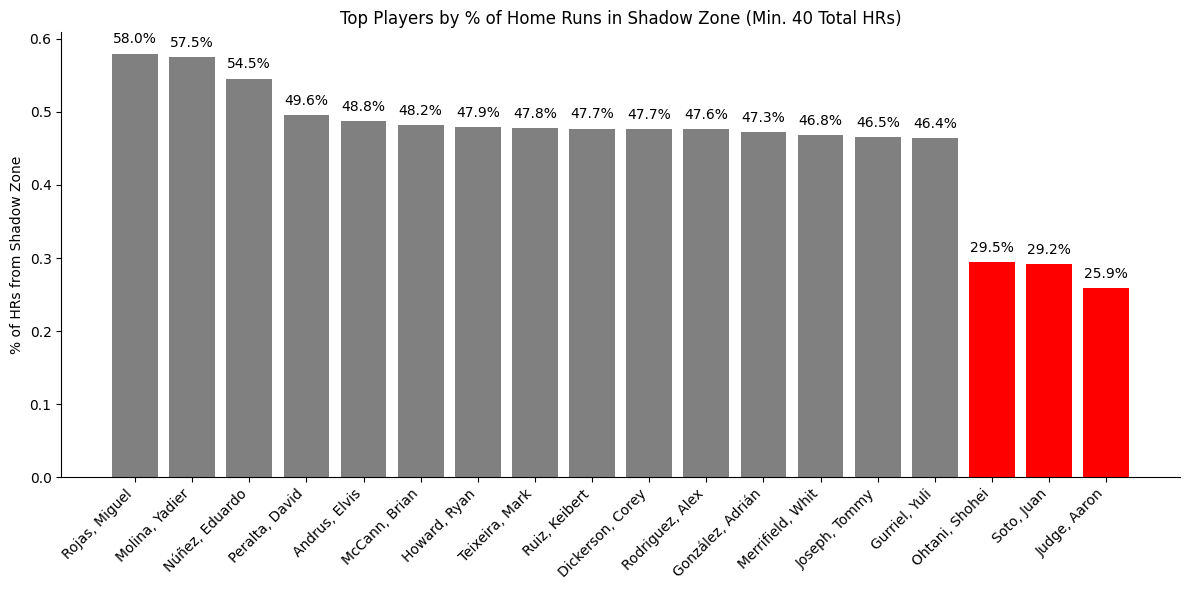

In [ ]:
# Total HRs in Shadow zone (zone == 2)
shadow_hr_count = true_location[true_location['zone'] == 2].groupby('player_name')['hrs'].sum().reset_index()
shadow_hr_count.columns = ['player_name', 'shadow_hrs']

# Total HRs across all zones
all_hr_count = true_location.groupby('player_name')['hrs'].sum().reset_index()
all_hr_count.columns = ['player_name', 'total_hrs']

# Merge and filter by minimum total HRs
hr_percent = pd.merge(shadow_hr_count, all_hr_count, on='player_name')
hr_percent = hr_percent[hr_percent['total_hrs'] >= 40]

# Calculate % of HRs from Shadow zone
hr_percent['percent_shadow_hr'] = hr_percent['shadow_hrs'] / hr_percent['total_hrs']

# Top 15 by shadow HR %
top15_shadow_hr = hr_percent.sort_values(by='percent_shadow_hr', ascending=False).head(15)

# Add comparison players
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_rows = hr_percent[hr_percent['player_name'].isin(comparison_names)]

# Combine and highlight
combined = pd.concat([top15_shadow_hr, comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)
combined = combined.sort_values(by='percent_shadow_hr', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['percent_shadow_hr'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

# Style
plt.title("Top Players by % of Home Runs in Shadow Zone (Min. 40 Total HRs)")
plt.ylabel("% of HRs from Shadow Zone")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Clean up plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

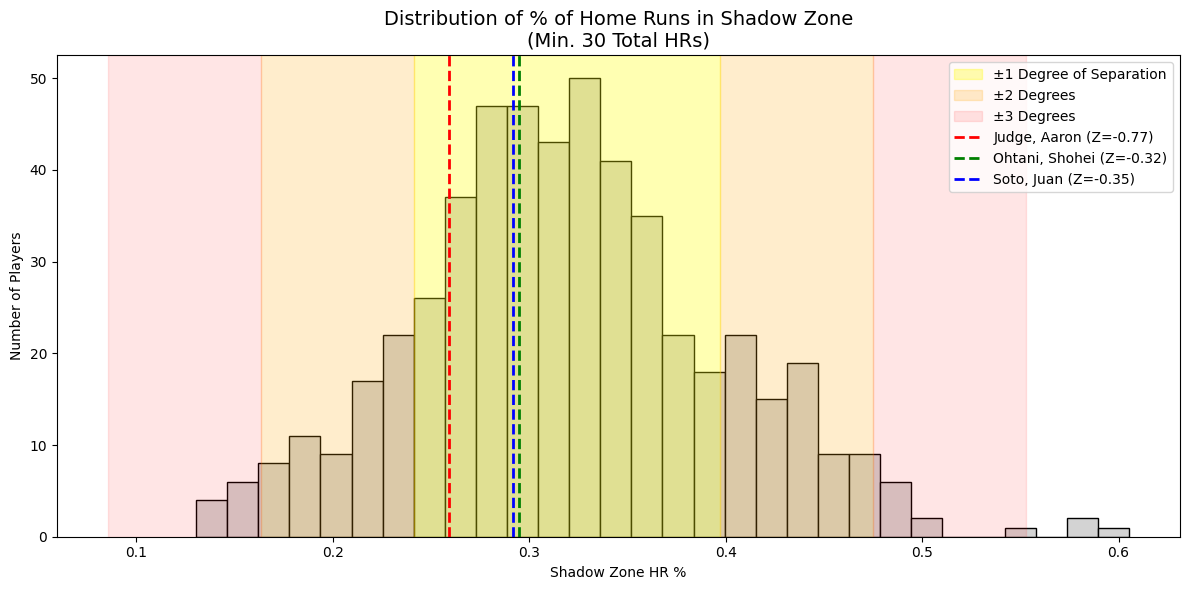

In [ ]:
# Total HRs in Shadow zone (zone == 2)
shadow_hr_count = true_location[true_location['zone'] == 2].groupby('player_name')['hrs'].sum().reset_index()
shadow_hr_count.columns = ['player_name', 'shadow_hrs']

# Total HRs across all zones
all_hr_count = true_location.groupby('player_name')['hrs'].sum().reset_index()
all_hr_count.columns = ['player_name', 'total_hrs']

# Merge and filter by minimum total HRs (30+)
hr_percent = pd.merge(shadow_hr_count, all_hr_count, on='player_name')
hr_percent = hr_percent[hr_percent['total_hrs'] >= 30]

# Calculate % of HRs from Shadow zone
hr_percent['percent_shadow_hr'] = hr_percent['shadow_hrs'] / hr_percent['total_hrs']

# Get data for Judge, Soto, Ohtani
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_scores = hr_percent[hr_percent['player_name'].isin(comparison_names)]

# Stats for standard deviations
mean = hr_percent['percent_shadow_hr'].mean()
std = hr_percent['percent_shadow_hr'].std()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(hr_percent['percent_shadow_hr'], bins=30, color='lightgray', edgecolor='black')

# Shaded degrees of separation
plt.axvspan(mean - std, mean + std, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.2, label='±2 Degrees')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.2)
plt.axvspan(mean - 3*std, mean - 2*std, color='red', alpha=0.1, label='±3 Degrees')
plt.axvspan(mean + 2*std, mean + 3*std, color='red', alpha=0.1)

# Plot vertical lines for key players
colors = {
    'Judge, Aaron': 'red',
    'Soto, Juan': 'blue',
    'Ohtani, Shohei': 'green'
}
for _, row in comparison_scores.iterrows():
    val = row['percent_shadow_hr']
    z = (val - mean) / std
    plt.axvline(x=val, color=colors[row['player_name']], linestyle='--', linewidth=2,
                label=f"{row['player_name']} (Z={z:+.2f})")

# Formatting
plt.title("Distribution of % of Home Runs in Shadow Zone\n(Min. 30 Total HRs)", fontsize=14)
plt.xlabel("Shadow Zone HR %")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

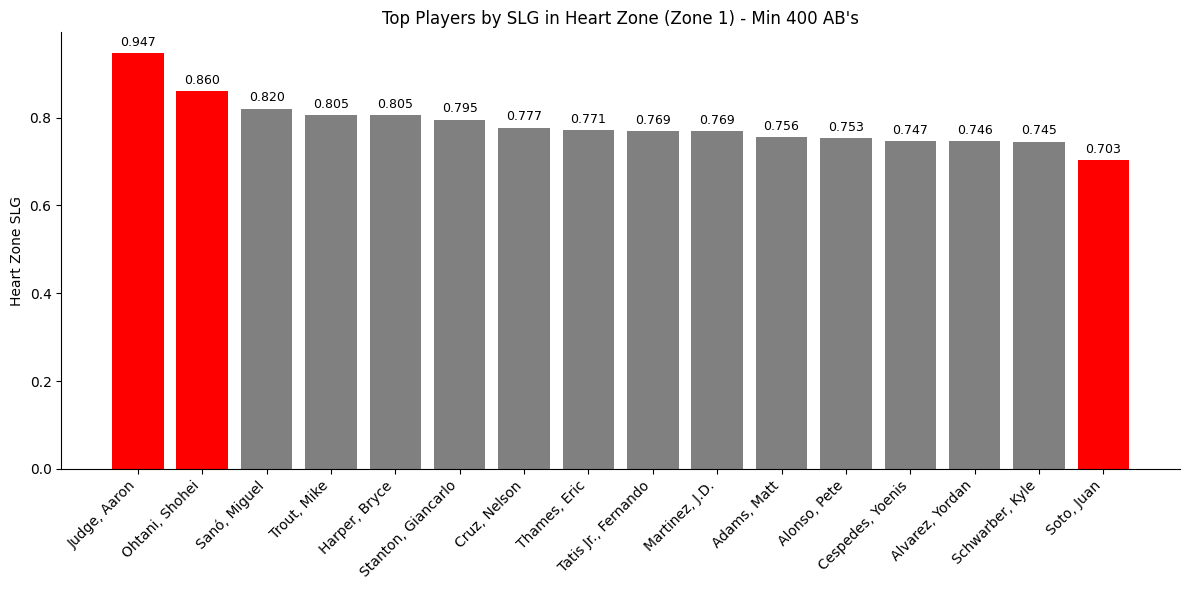

In [ ]:
# Filter for Heart zone only
heart_zone = true_location[true_location['zone'] == 1].copy()

# Average SLG by player in Heart zone
heart_slg = heart_zone.groupby('player_name').agg({
    'slg': 'mean',
    'abs': 'sum'
}).reset_index()

# Filter to avoid players with no at-bats
heart_slg = heart_slg[heart_slg['abs'] > 400]

# Top 15 by Heart zone SLG
top15 = heart_slg.sort_values(by='slg', ascending=False).head(15)

# Add Judge, Soto, Ohtani
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_rows = heart_slg[heart_slg['player_name'].isin(comparison_names)]

# Combine and highlight
combined = pd.concat([top15, comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)
combined = combined.sort_values(by='slg', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['slg'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Add SLG labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Style
plt.title("Top Players by SLG in Heart Zone (Zone 1) - Min 400 AB's")
plt.ylabel("Heart Zone SLG")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Clean borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

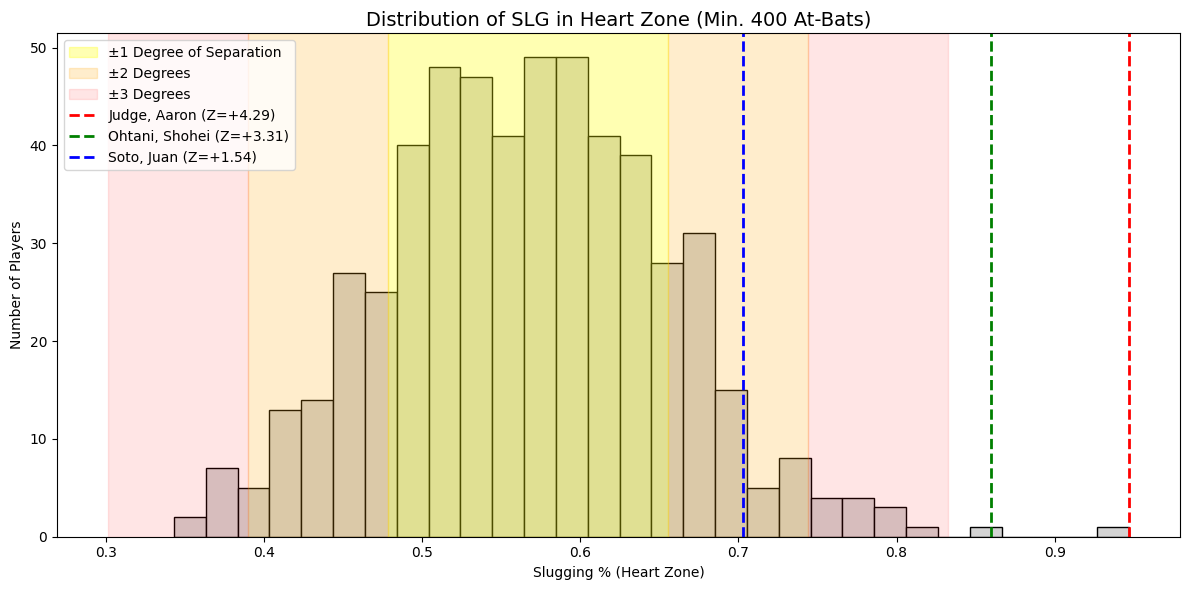

In [ ]:
# Filter for Heart zone (Zone 1)
heart_zone = true_location[true_location['zone'] == 1].copy()

# Average SLG per player in Heart zone
heart_slg = heart_zone.groupby('player_name').agg({
    'slg': 'mean',
    'abs': 'sum'
}).reset_index()

# Filter for players with at least 30 at-bats in Heart zone
heart_slg = heart_slg[heart_slg['abs'] >= 400]

# Get data for comparison players
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_scores = heart_slg[heart_slg['player_name'].isin(comparison_names)]

# Mean and standard deviation
mean = heart_slg['slg'].mean()
std = heart_slg['slg'].std()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(heart_slg['slg'], bins=30, color='lightgray', edgecolor='black')

# Degrees of separation shading
plt.axvspan(mean - std, mean + std, color='yellow', alpha=0.3, label='±1 Degree of Separation')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.2, label='±2 Degrees')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.2)
plt.axvspan(mean - 3*std, mean - 2*std, color='red', alpha=0.1, label='±3 Degrees')
plt.axvspan(mean + 2*std, mean + 3*std, color='red', alpha=0.1)

# Add markers for key players
colors = {
    'Judge, Aaron': 'red',
    'Soto, Juan': 'blue',
    'Ohtani, Shohei': 'green'
}
for _, row in comparison_scores.iterrows():
    val = row['slg']
    z = (val - mean) / std
    plt.axvline(x=val, color=colors[row['player_name']], linestyle='--', linewidth=2,
                label=f"{row['player_name']} (Z={z:+.2f})")

# Final touches
plt.title("Distribution of SLG in Heart Zone (Min. 400 At-Bats)", fontsize=14)
plt.xlabel("Slugging % (Heart Zone)")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

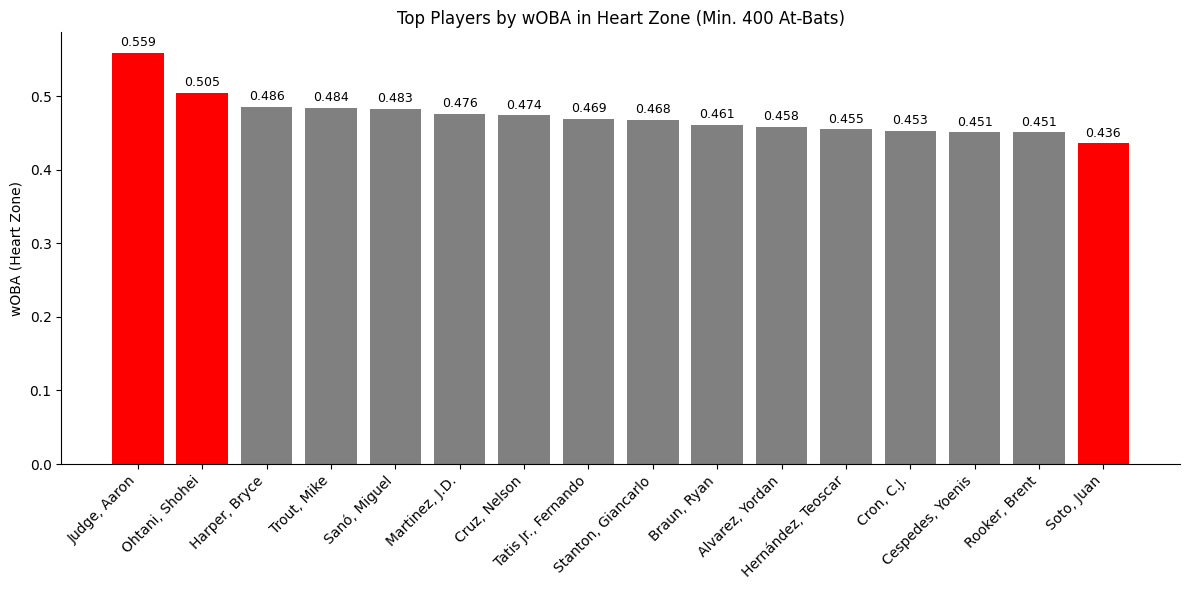

In [ ]:
# Filter for Heart zone (Zone 1)
heart_zone = true_location[true_location['zone'] == 1].copy()

# Group by player to calculate average wOBA and total at-bats
heart_woba = heart_zone.groupby('player_name').agg({
    'woba': 'mean',
    'abs': 'sum'
}).reset_index()

# Filter to players with at least 400 at-bats
heart_woba = heart_woba[heart_woba['abs'] >= 400]

# Sort and get top 15 by wOBA
top15_woba = heart_woba.sort_values(by='woba', ascending=False).head(15)

# Add comparison players (even if not in top 15)
comparison_names = ['Judge, Aaron', 'Soto, Juan', 'Ohtani, Shohei']
comparison_rows = heart_woba[heart_woba['player_name'].isin(comparison_names)]

# Combine, highlight, and sort
combined = pd.concat([top15_woba, comparison_rows]).drop_duplicates(subset='player_name')
combined['highlight'] = combined['player_name'].isin(comparison_names)
combined = combined.sort_values(by='woba', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    combined['player_name'],
    combined['woba'],
    color=combined['highlight'].map({True: 'red', False: 'gray'})
)

# Add wOBA labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Style
plt.title("Top Players by wOBA in Heart Zone (Min. 400 At-Bats)")
plt.ylabel("wOBA (Heart Zone)")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Clean up borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


#merge data

In [ ]:
hitting_stats = pd.read_csv('/content/hitting_stats.csv')

# Clean and standardize column names
true_location.columns = true_location.columns.str.strip()
hitting_stats.columns = hitting_stats.columns.str.strip()

# Standardize name columns for joining
true_location['player_name'] = true_location['player_name'].str.strip()
hitting_stats['player_name'] = hitting_stats['last_name, first_name'].str.strip()

# Aggregate pitch counts by zone and player
zone_distribution = true_location.groupby(['player_name', 'zone'])['pitches'].sum().reset_index()

# Calculate total pitches per player
total_pitches = zone_distribution.groupby('player_name')['pitches'].sum().reset_index(name='total_pitches')

# Pivot zones into columns
zone_pivot = zone_distribution.pivot(index='player_name', columns='zone', values='pitches').fillna(0)

# Merge total pitches into the pivot table
zone_pivot = zone_pivot.merge(total_pitches, on='player_name')
zone_pivot.columns.name = None

# Calculate percentage of pitches in each zone
for zone in [1, 2, 3, 4]:
    zone_pivot[f'zone_{zone}_pct'] = zone_pivot[zone] / zone_pivot['total_pitches']

# Select relevant zone-based features
zone_features = zone_pivot[['player_name', 'zone_1_pct', 'zone_2_pct', 'zone_3_pct', 'zone_4_pct', 'total_pitches']]

# Merge zone features with hitting statistics
merged_data = pd.merge(zone_features, hitting_stats, on='player_name', how='inner')

# Display merged dataset
print(merged_data.head())

   player_name  zone_1_pct  zone_2_pct  zone_3_pct  zone_4_pct  total_pitches  \
0   Abrams, CJ    0.287854    0.475907    0.236239    0.000000           5541   
1   Abrams, CJ    0.287854    0.475907    0.236239    0.000000           5541   
2   Abrams, CJ    0.287854    0.475907    0.236239    0.000000           5541   
3   Abrams, CJ    0.287854    0.475907    0.236239    0.000000           5541   
4  Abreu, José    0.252003    0.412268    0.234516    0.101213          21845   

  last_name, first_name  player_id  year   pa  ...   woba  xwoba  \
0            Abrams, CJ     682928  2022  302  ...  0.267  0.266   
1            Abrams, CJ     682928  2023  614  ...  0.306  0.304   
2            Abrams, CJ     682928  2024  602  ...  0.322  0.319   
3            Abrams, CJ     682928  2025  151  ...  0.382  0.379   
4           Abreu, José     547989  2015  668  ...  0.361  0.338   

   sweet_spot_percent  barrel_batted_rate  hard_hit_percent  avg_best_speed  \
0                28.6    

🔧 Data Merge Steps
Load Both Datasets:

true_zone.csv contains pitch count data per player across four defined zones (1 = Heart, 2 = Shadow, 3 = Chase, 4 = Waste).

hitting_stats.csv contains advanced hitting metrics for each player.

Standardize Player Names:

Cleaned and aligned the player_name columns in both datasets to ensure accurate merging.

Aggregate Pitch Counts:

Summed the number of pitches thrown to each player in each zone.

Calculate Total Pitches:

Computed the total number of pitches seen by each player.

Pivot Zone Data:

Transformed the dataset so that each zone became its own column with pitch counts.

Compute Zone Percentages:

Calculated the percentage of total pitches that each player saw in each zone.

Merge Datasets:

Joined the zone percentage features with the hitting statistics using player_name as the key.

📊 How to Use the Merged Data for Modeling
This merged dataset can now be used for a variety of analyses, such as:

✅ 1. Multiple Linear Regression
Predict a player’s zone percentage (e.g., zone_1_pct) using performance stats like wOBA, BB%, K%, SLG, etc.

Helps determine which offensive traits correlate with getting more pitches in or out of the strike zone.

🌲 2. Random Forest
Classify or rank players based on which stats most strongly influence zone exposure.

Useful for identifying nonlinear relationships and feature importance.

⚡ 3. XGBoost (Extreme Gradient Boosting)
Provides a powerful, optimized model for predicting zone coverage patterns using hitting metrics.

Good for both classification and regression depending on the modeling goal.

In [ ]:
# Clean columns
true_location.columns = true_location.columns.str.strip()
hitting_stats.columns = hitting_stats.columns.str.strip()

# Standardize player name fields
true_location['player_name'] = true_location['player_name'].str.strip()
hitting_stats['player_name'] = hitting_stats['last_name, first_name'].str.strip()

# Aggregate pitch counts by zone and player
zone_distribution = true_location.groupby(['player_name', 'zone'])['pitches'].sum().reset_index()

# Total pitches per player
total_pitches = zone_distribution.groupby('player_name')['pitches'].sum().reset_index(name='total_pitches')

# Pivot zones into columns
zone_pivot = zone_distribution.pivot(index='player_name', columns='zone', values='pitches').fillna(0)
zone_pivot = zone_pivot.merge(total_pitches, on='player_name')
zone_pivot.columns.name = None

# Calculate zone percentages
for z in [1, 2, 3, 4]:
    zone_pivot[f'zone_{z}_pct'] = zone_pivot[z] / zone_pivot['total_pitches']

# Select relevant features
zone_features = zone_pivot[['player_name', 'zone_1_pct', 'zone_2_pct', 'zone_3_pct', 'zone_4_pct', 'total_pitches']]

# Merge with hitting stats
merged = pd.merge(zone_features, hitting_stats, on='player_name', how='inner')

# Define regression input
target = 'zone_1_pct'
predictors = [
    'slg_percent', 'woba', 'xwoba', 'xslg',
    'barrel_batted_rate', 'hard_hit_percent',
    'swing_percent', 'whiff_percent', 'oz_contact_percent'
]

# Drop missing values
model_data = merged.dropna(subset=[target] + predictors)

# Prepare X and y
X = sm.add_constant(model_data[predictors])
y = model_data[target]

# Fit model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             zone_1_pct   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     71.47
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          1.11e-123
Time:                        18:53:46   Log-Likelihood:                 7533.3
No. Observations:                4460   AIC:                        -1.505e+04
Df Residuals:                    4450   BIC:                        -1.498e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5320      0

In [ ]:
# Define features and target
features = [
    'slg_percent', 'woba', 'xwoba', 'xslg',
    'barrel_batted_rate', 'hard_hit_percent',
    'swing_percent', 'whiff_percent', 'oz_contact_percent'
]
target = 'zone_1_pct'

# Drop missing values
xgb_data = merged.dropna(subset=features + [target])
X = xgb_data[features]
y = xgb_data[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit XGBoost with fewer trees for speed
xgb_model = XGBRegressor(random_state=42, n_estimators=50, max_depth=3)
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"R²: {r2:.3f}, RMSE: {rmse:.4f}")

R²: 0.093, RMSE: 0.0414


Yes, this model supports your core thesis:

The way pitchers attack hitters (especially how often they pitch to them in the heart of the zone) is not strongly correlated with performance metrics like SLG, wOBA, or contact quality.

This suggests that factors not included in the data — like:

Game situation

Batter reputation

Pitcher intent or command

Catcher framing

Team strategies

Historical batter-pitcher matchups
— likely play a much larger role in zone placement.

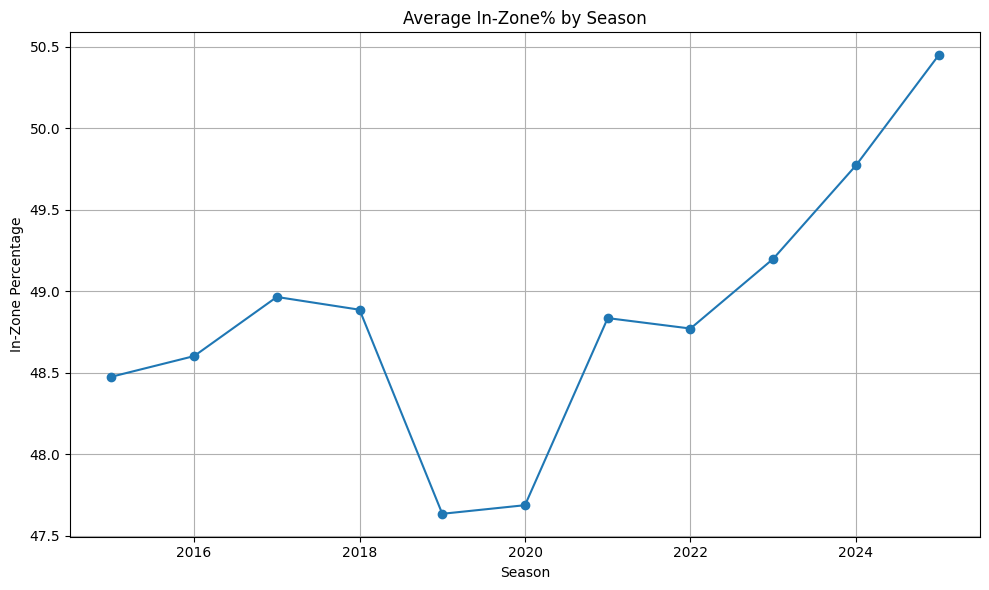

In [ ]:
# Load data
location_only = pd.read_csv('/content/location_only.csv')
location_only.columns = location_only.columns.str.strip()

# Clean and convert
location_only['year'] = pd.to_numeric(location_only['year'], errors='coerce')
location_only['in_zone_percent'] = pd.to_numeric(location_only['in_zone_percent'], errors='coerce')
location_data = location_only.dropna(subset=['year', 'in_zone_percent'])

# Aggregate by year
in_zone_by_year = location_data.groupby('year')['in_zone_percent'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(in_zone_by_year['year'], in_zone_by_year['in_zone_percent'], marker='o')
plt.title('Average In-Zone% by Season')
plt.xlabel('Season')
plt.ylabel('In-Zone Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()

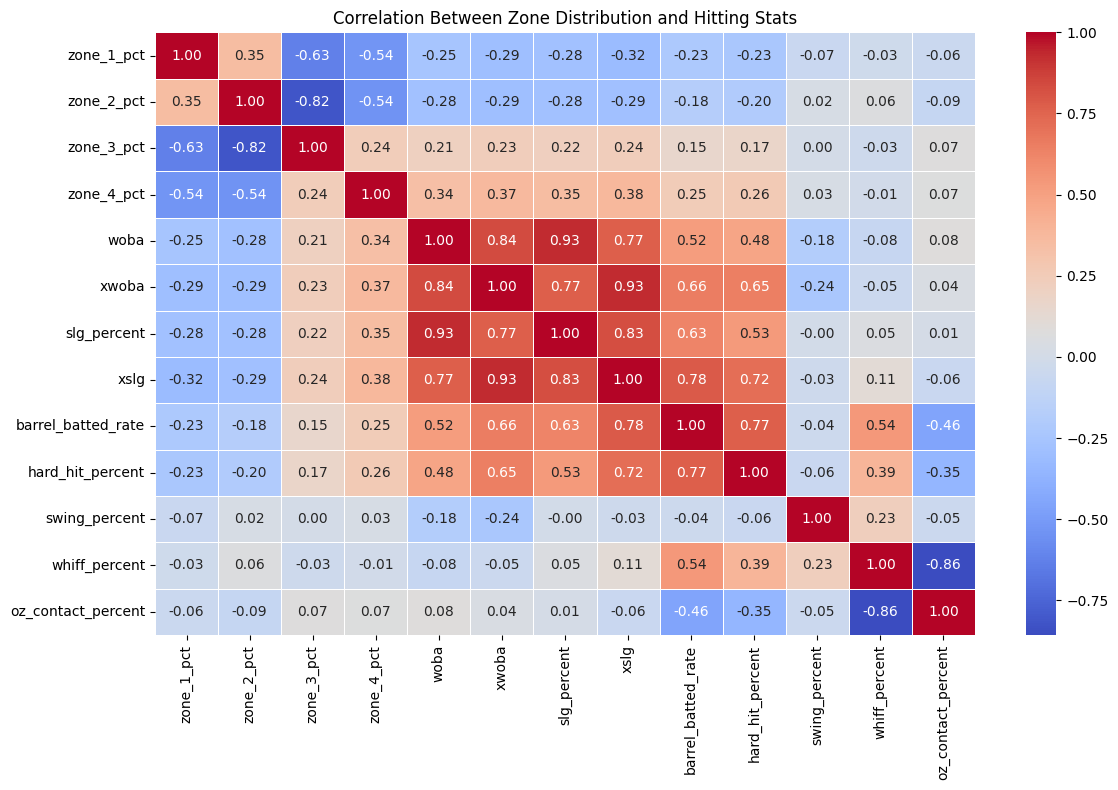

In [ ]:
# Select zone and hitting stats columns
corr_columns = [
    'zone_1_pct', 'zone_2_pct', 'zone_3_pct', 'zone_4_pct',
    'woba', 'xwoba', 'slg_percent', 'xslg', 'barrel_batted_rate',
    'hard_hit_percent', 'swing_percent', 'whiff_percent', 'oz_contact_percent'
]

# Filter the relevant data
corr_data = merged_data[corr_columns].dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Zone Distribution and Hitting Stats")
plt.tight_layout()
plt.show()

🔴 Zone 1 (Heart of the plate)
Negative correlation with wOBA (-0.25), xwOBA (-0.29), SLG (-0.28), xSLG (-0.32)
→ Better hitters tend to see fewer pitches in the heart. That supports your thesis.

Also negatively correlated with barrel rate and hard hit rate, suggesting pitchers avoid throwing down the middle to hitters who do damage.

🟠 Zone 2 (Shadow)
Moderate negative correlation with xwOBA/xSLG (-0.29)
→ Slight tendency to avoid the shadow for strong hitters, though weaker than for heart.

🟡 Zone 3 (Chase)
Positive correlation with xwOBA, SLG, etc. (~+0.2)
→ Slightly more chase pitches thrown to better hitters, maybe as a strategy to avoid contact.

⚪ Zone 4 (Waste)
Positive correlation with hitting stats (~+0.35)
→ Better hitters get more waste pitches — again likely a reflection of pitchers trying to avoid damage.

Summary:
There’s a clear inverse relationship between hitting quality and how often pitchers attack the heart and shadow zones.

Meanwhile, waste and chase zones are positively correlated, likely used to neutralize strong hitters.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, plot_importance

## XG boost to show stats correlation to zone-1 percentage.

In [ ]:
# Define features and target
features = [
    'slg_percent', 'woba', 'xwoba', 'xslg',
    'barrel_batted_rate', 'hard_hit_percent',
    'swing_percent', 'whiff_percent', 'oz_contact_percent'
]
target = 'zone_1_pct'

# Drop missing values
xgb_data = merged_data.dropna(subset=features + [target])
X = xgb_data[features]
y = xgb_data[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit XGBoost model
xgb_model = XGBRegressor(random_state=42, n_estimators=50, max_depth=3)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Fixed: manual RMSE calculation

print(f'R²: {r2:.3f}')
print(f'RMSE: {rmse:.4f}')

R²: 0.093
RMSE: 0.0414


Quantiles of hitting

                            sum_sq       df             F         PR(>F)
C(hitter_tier)            0.266825      2.0     32.147074   1.180762e-14
C(zone)                 157.195377      2.0  18938.892758   0.000000e+00
C(hitter_tier):C(zone)    2.729792      4.0    164.442624  1.165856e-137
Residual                 55.490556  13371.0           NaN            NaN


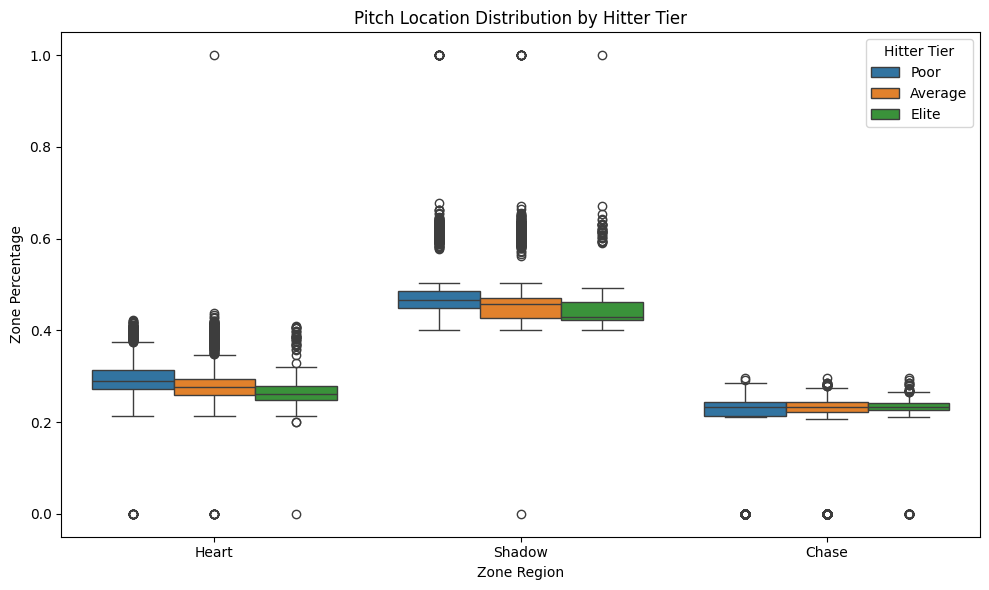

In [ ]:
# Define tiers based on wOBA (top 20% = elite, bottom 20% = poor, rest = average)
quantiles = merged_data['woba'].quantile([0.2, 0.8])
low, high = quantiles[0.2], quantiles[0.8]

def label_tier(woba):
    if woba >= high:
        return 'Elite'
    elif woba <= low:
        return 'Poor'
    else:
        return 'Average'

merged_data['hitter_tier'] = merged_data['woba'].apply(label_tier)

# Melt for ANOVA and plotting
melted = pd.melt(
    merged_data[['hitter_tier', 'zone_1_pct', 'zone_2_pct', 'zone_3_pct']],
    id_vars='hitter_tier',
    var_name='zone',
    value_name='zone_pct'
)

# Rename zones for clarity
zone_label_map = {
    'zone_1_pct': 'Heart',
    'zone_2_pct': 'Shadow',
    'zone_3_pct': 'Chase'
}
melted['zone'] = melted['zone'].map(zone_label_map)

# Run ANOVA
model = ols('zone_pct ~ C(hitter_tier) * C(zone)', data=melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Plot distribution of zone % per tier
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x='zone', y='zone_pct', hue='hitter_tier')
plt.title('Pitch Location Distribution by Hitter Tier')
plt.ylabel('Zone Percentage')
plt.xlabel('Zone Region')
plt.legend(title='Hitter Tier')
plt.tight_layout()
plt.show()


The two-way ANOVA model tells us whether two factors — hitter quality (Elite, Average, Poor) and pitch zone (Heart, Shadow, Chase) — meaningfully affect how pitches are distributed, and whether these two factors interact.

In this case, all effects were statistically significant, which means that the differences we observe in the data — between how elite hitters are pitched to versus poor hitters, and across different zones — are unlikely to be due to random chance alone. The p-values for the hitter tier, zone, and their interaction were all extremely low (well below the common threshold of 0.05), confirming that the model has picked up real patterns in the data.

However, statistical significance doesn't always mean practical significance. When we look at the boxplot, we can see that although the average pitch distributions vary slightly between hitter tiers, the overall spread and overlap of the distributions are large. That means pitchers aren't drastically changing their approach based on hitter quality — elite hitters are pitched to in much the same way as poor hitters.

In essence:

Yes, the data shows real, measurable differences.

But those differences are small in size.

Pitchers seem to follow a fairly consistent strategy, regardless of who is at the plate.

This suggests that while pitchers may make slight tactical adjustments, they are largely not tailoring pitch locations significantly to the caliber of the hitter — possibly due to limitations in command, risk aversion, or broader pitching philosophies.

**Chart Description:**

This boxplot shows the distribution of pitch locations—categorized into Heart, Shadow, and Chase zones—across different tiers of hitters (Poor, Average, Elite). Each box represents how often pitches were thrown to each zone, depending on hitter quality. While Elite hitters receive slightly fewer pitches in the Heart zone and slightly more in the Shadow, the overlap between groups is substantial. This visual reinforces the statistical conclusion: pitchers make only marginal adjustments based on hitter quality, with a broadly consistent pitch location strategy across the board.

## Pitch Types

<ipython-input-43-3053437004>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pitch_data[pitch_columns] = pitch_data[pitch_columns].applymap(lambda x: x * 100 if x <= 1 else x)


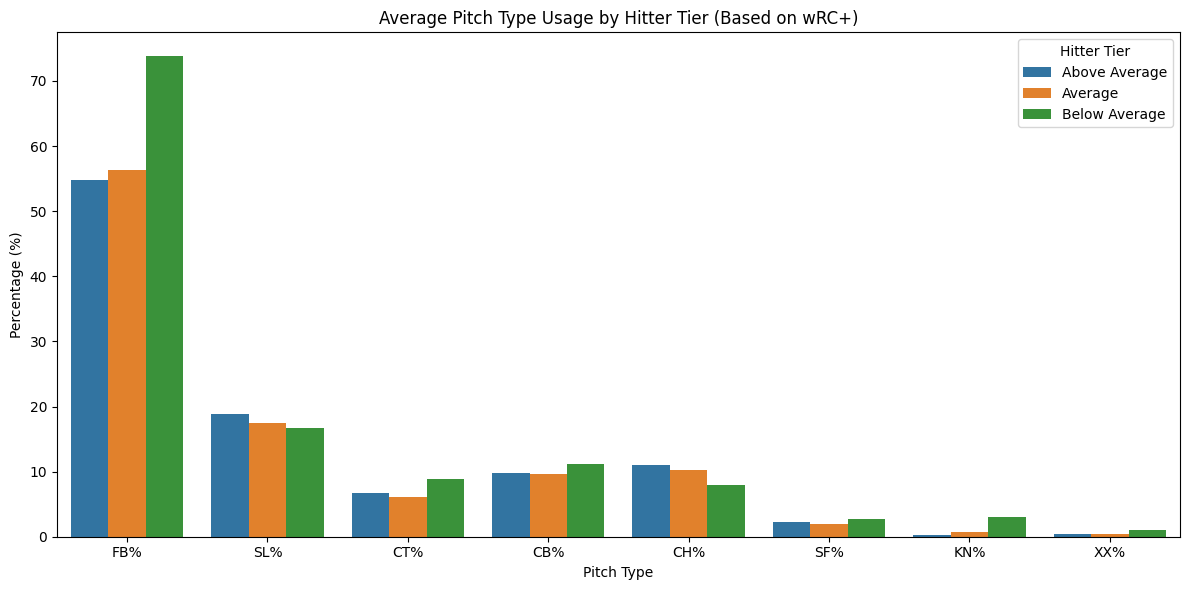

In [ ]:
# Load and clean data
pitch_data = pd.read_csv('pitch_type.csv')  # Adjust path if needed
pitch_data.columns = pitch_data.columns.str.strip()

# Create hitter tier labels based on quantiles of wRC+
quantiles = pitch_data['wRC+'].quantile([0.33, 0.66])
low, high = quantiles[0.33], quantiles[0.66]

def tier_group(wrc_plus):
    if wrc_plus <= low:
        return 'Below Average'
    elif wrc_plus >= high:
        return 'Above Average'
    else:
        return 'Average'

pitch_data['hitter_tier'] = pitch_data['wRC+'].apply(tier_group)

# Identify pitch percentage columns
pitch_columns = ['FB%', 'SL%', 'CT%', 'CB%', 'CH%', 'SF%', 'KN%', 'XX%']

# Adjust if any value is in proportion (e.g., 0.5 instead of 50)
pitch_data[pitch_columns] = pitch_data[pitch_columns].applymap(lambda x: x * 100 if x <= 1 else x)

# Compute average pitch type usage by hitter tier
pitch_mix = pitch_data.groupby('hitter_tier')[pitch_columns].mean().reset_index()

# Reshape for plotting
melted = pitch_mix.melt(id_vars='hitter_tier', var_name='Pitch Type', value_name='Percentage')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Pitch Type', y='Percentage', hue='hitter_tier')
plt.title('Average Pitch Type Usage by Hitter Tier (Based on wRC+)')
plt.ylabel('Percentage (%)')
plt.xlabel('Pitch Type')
plt.legend(title='Hitter Tier')
plt.tight_layout()
plt.show()

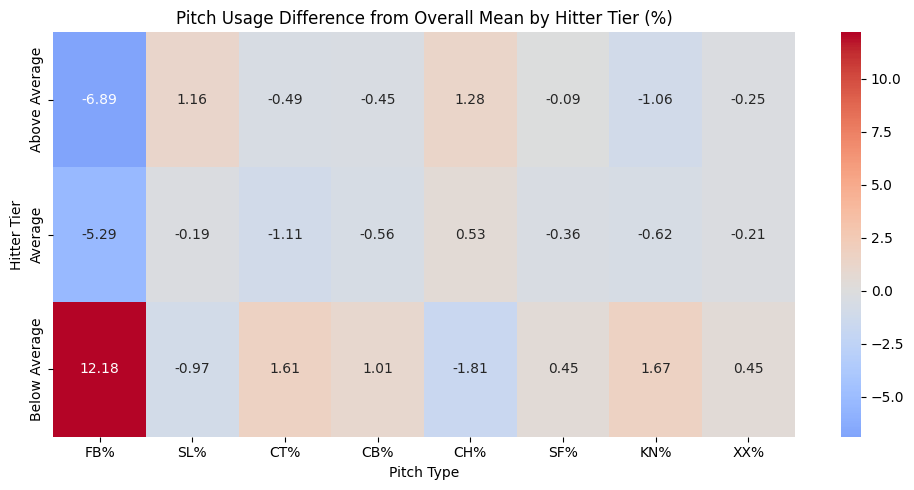

In [ ]:
# Convert pitch percentages to proportion for correct scaling
proportional_mix = pitch_mix.copy()
proportional_mix[pitch_columns] = proportional_mix[pitch_columns] / 100

# Center values by subtracting the mean
heatmap_data = proportional_mix.set_index('hitter_tier')[pitch_columns] - proportional_mix[pitch_columns].mean()

# Plot heatmap with percentage format
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data * 100, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Pitch Usage Difference from Overall Mean by Hitter Tier (%)')
plt.ylabel('Hitter Tier')
plt.xlabel('Pitch Type')
plt.tight_layout()
plt.show()


This heatmap shows how each hitter tier (based on wRC+) deviates from the league-average pitch mix across eight pitch types. The numbers represent percentage point differences from the mean. For example, "Below Average" hitters see fastballs (FB%) about 12.18 percentage points more often than the league average, while "Above Average" hitters see them 6.89 points less.

Key takeaways:

Below Average hitters are overwhelmingly attacked with more fastballs, suggesting pitchers are more aggressive or challenge them.

Above Average hitters receive fewer fastballs, indicating pitchers may avoid giving them easier pitches to hit.

There's subtle variation in offspeed and breaking pitches, but the clearest divergence is in fastball usage.

📊 This visualization supports the idea that pitch selection does adjust with hitter quality — but primarily through the use of fastballs.

In [ ]:
# Show all column names to identify pitch types
print(pitch_data.columns.tolist())


['Name', 'Team', 'HR', 'SLG', 'wOBA', 'WAR', 'wRC+', 'FB%', 'SL%', 'CT%', 'CB%', 'CH%', 'SF%', 'KN%', 'XX%', 'NameASCII', 'PlayerId', 'MLBAMID', 'hitter_tier']


<ipython-input-46-2522890092>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pitch_data[fastballs + offspeeds] = pitch_data[fastballs + offspeeds].applymap(lambda x: x * 100 if x <= 1 else x)


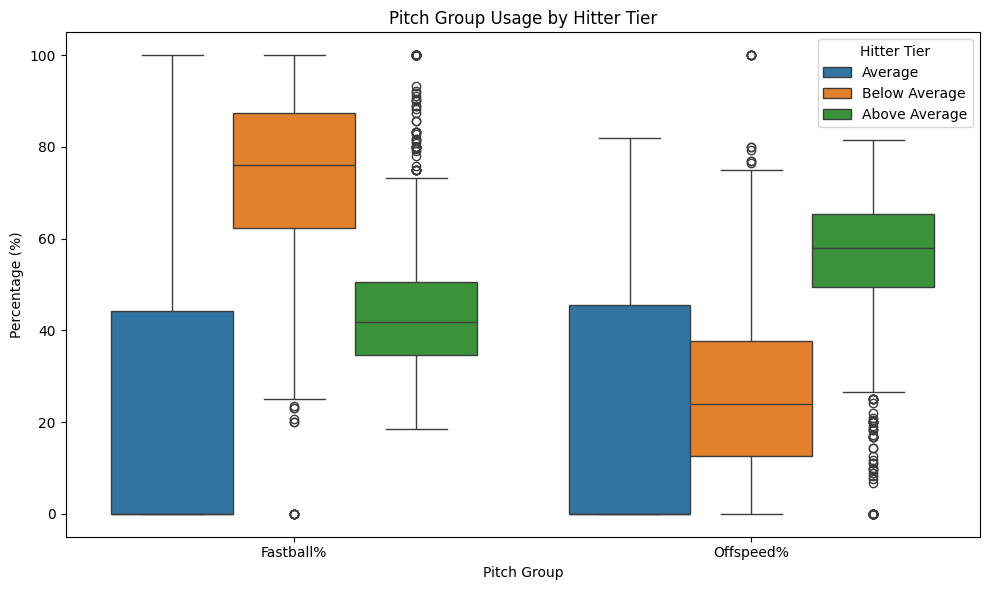

In [ ]:
# Identify pitch types
fastballs = ['FB%', 'CT%']
offspeeds = ['SL%', 'CB%', 'CH%', 'SF%', 'KN%', 'XX%']

# Convert to consistent scale (0-100%)
pitch_data[fastballs + offspeeds] = pitch_data[fastballs + offspeeds].applymap(lambda x: x * 100 if x <= 1 else x)

# Normalize pitch percentages to prevent totals > 100%
total_pct = pitch_data[fastballs + offspeeds].sum(axis=1)
pitch_data[fastballs + offspeeds] = pitch_data[fastballs + offspeeds].div(total_pct, axis=0) * 100

# Create new columns for pitch group sums
pitch_data['Fastball%'] = pitch_data[fastballs].sum(axis=1)
pitch_data['Offspeed%'] = pitch_data[offspeeds].sum(axis=1)

# Melt for plotting
melted_all = pitch_data[['Fastball%', 'Offspeed%', 'hitter_tier']].melt(
    id_vars='hitter_tier',
    var_name='Pitch Group',
    value_name='Percentage'
)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_all, x='Pitch Group', y='Percentage', hue='hitter_tier')
plt.title('Pitch Group Usage by Hitter Tier')
plt.ylabel('Percentage (%)')
plt.xlabel('Pitch Group')
plt.legend(title='Hitter Tier')
plt.tight_layout()
plt.show()

This chart shows how often different types of hitters — based on their performance — are thrown fastballs versus offspeed pitches.

- The chart is split into two pitch groups: Fastball% on the left and Offspeed% on the right.

- Each group is broken down by hitter quality: Below Average, Average, and Above Average (based on a stat called wRC+).

- The taller the boxes, the more variety there is among hitters in that group; the horizontal lines inside the boxes show the typical (median) percentage.

What it tells us:
- Below Average hitters (orange) tend to see more fastballs — their boxes for Fastball% are higher than the other groups.

- Above Average hitters (green) see more offspeed pitches — their Offspeed% boxes are higher than the rest.

- Average hitters (blue) fall somewhere in between for both pitch types, but with more variation.

In simple terms: better hitters face more offspeed stuff, while weaker hitters are challenged more often with fastballs.

In [ ]:
!jupyter nbconvert --to html "zone_article.ipynb"

[NbConvertApp] Converting notebook zone_article.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 19 image(s).
[NbConvertApp] Writing 2163644 bytes to zone_article.html
